In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install silence_tensorflow
!pip install pycm
!pip install lime
!pip install transformers
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp37-none-any.whl size=3743 sha256=67ee7b2ddb21ff933b48c4baf3ddd543560e84448165205be4ab590a0a7747f3
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow
     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 573kB 20.4MB/s 
     |████████████████████████████████| 276kB 10.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=552dfd4dce97d07a224027e51faf50212bc76fd04ecc0ef28a0f221bc1418ebc
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.0MB 10.8MB/s 
     |████████████████████████████████| 890kB 40.0MB/s 
     |████████████████████████████████| 3.2MB 34.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-no

True

In [4]:
import os
default_path = "/content/gdrive/MyDrive/Colab Notebooks/Automatic Software Artifacts"
os.chdir(default_path)

In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, LSTM, SpatialDropout1D, Input, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import nltk
import re
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pycm import *
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import layers, preprocessing as kprocessing
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
## for bert language model
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB

from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

import utils_functions as uf

import matplotlib as mpl
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "k", "c"]) 

np.random.seed(7)

### Some Utils Functions

In [6]:
# '''
# Compute different text length metrics.
# :parameter
#     :param dtf: dataframe - dtf with a text column
#     :param column: string - name of column containing text
# :return
#     dtf: input dataframe with 2 new columns
# '''
def add_text_length(dtf, column):
    dtf['word_count'] = dtf[column].apply(lambda x: len(str(x).split(" ")))
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(str(x).split(".")))
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf

In [8]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def display_closestwords_tsnescatterplot(word_vect, dim, words):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]
    
    # add the vector for each of the closest words to the array
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([word_vect[word]]), axis=0)
        close_words +=model.similar_by_word(word)
        
    for wrd_score in close_words:
        wrd_vector = word_vect[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
def tsne_plot(word_vect, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(word_vect[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### Read and Show a Data Sample

In [9]:
file = 'dataset.csv'
df = pd.read_csv(file,encoding='ISO-8859-1')

labels = df.NumLabel
labels = labels.to_numpy()

In [10]:
df.sample(5)

Label  ...                                           FileName
11       Design Document  ...  ../MSRDataset/Oracle/Design Document/2521-dock...
128              License  ...  ../MSRDataset/Oracle/License/21787-elephant.io...
158  Contributors' Guide  ...  ../MSRDataset/Oracle/Contributors' Guide/15685...
98               License  ...  ../MSRDataset/Oracle/License/21443-socket.io-n...
131  Contributors' Guide  ...  ../MSRDataset/Oracle/Contributors' Guide/5371-...

[5 rows x 4 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     208 non-null    object
 1   NumLabel  208 non-null    int64 
 2   Text      208 non-null    object
 3   FileName  208 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.6+ KB


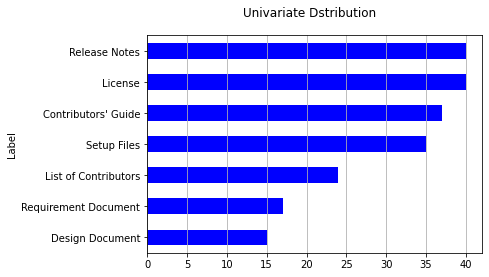

In [11]:
fig, ax = plt.subplots()
fig.suptitle("Univariate Dstribution", fontsize=12)
df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Run Preprocessing Function to Clean Text

In [12]:
# Load stopwords from NLTK
lst_stopwords = nltk.corpus.stopwords.words("english")
df["text_clean"] = df["Text"].apply(lambda x: 
                      uf.utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
                      lst_stopwords=lst_stopwords))
df.sample(5)

Label  ...                                         text_clean
31   List of Contributors  ...  copyrightbegin copyright ericsson ab right res...
205         Release Notes  ...  fix fix statu code error supervisord superviso...
60            Setup Files  ...  name devic j version homepag http github com m...
30   List of Contributors  ...             origin author nicla eklund contributor
6         Design Document  ...  mechan form span class docwarn document need r...

[5 rows x 5 columns]

### Text Length Analysis

In [13]:
dtf = add_text_length(df, "text_clean")
dtf.head()

                      min         mean            max
word_count            3.0  1186.144231   40837.000000
char_count           16.0  5896.274038  206636.000000
sentence_count        1.0     1.000000       1.000000
avg_word_length       3.5     5.384789       7.153846
avg_sentence_lenght   3.0  1186.144231   40837.000000


Label  NumLabel  ... avg_word_length avg_sentence_lenght
0  Design Document         0  ...        5.848290              2485.0
1  Design Document         0  ...        6.759398               133.0
2  Design Document         0  ...        5.572539               772.0
3  Design Document         0  ...        5.173957               983.0
4  Design Document         0  ...        6.333333                 3.0

[5 rows x 10 columns]

### Feature Engineering - Tf-Idf (advanced variant of BoW)

In [14]:
# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

### Create the feature matrix

In [ ]:
corpus = df["text_clean"]
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

# sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1,
#             cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
len(dic_vocabulary)

10000

In [ ]:
# The position of a certain word (example)
word = "space"
dic_vocabulary[word]

8316

### Feature Selection
In order to drop some columns and reduce the matrix dimensionality:
  1. Treat each category as binary (for example, the “Design Document” category is 1 and 0 for the others);  
  2. Perform a Chi-Square test to determine whether a feature and the (binary) target are independent;  
  3. keep only the features with a certain p-value from the Chi-Square test.

In [ ]:
y = df["Label"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.90
df_features = pd.DataFrame()
print("Initial dimension", len(X_names))
# perform a Chi-Square test to determine whether a feature and the (binary) target are independent
# keep only the features with a certain p-value from the Chi-Square test.
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "Label":cat}))
    df_features = df_features.sort_values(["Label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()
print("Final dimension", len(X_names))

Initial dimension 10000
Final dimension 354


### Selected Features Sample

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(df_features[df_features["Label"]==cat]))
   print("  . top features:", ",".join(
df_features[df_features["Label"]==cat]["feature"].values[:10]))
   print(" ")

# Contributors' Guide:
  . selected features: 25
  . top features: pull request,pull,request,test,issu,mechan,selenium,plea,fork,cla
 
# Design Document:
  . selected features: 47
  . top features: design pattern,counter,messageloggerq,messageloggerscrib,item,breakpoint,observ,autoexcept,pattern,messagesend
 
# License:
  . selected features: 174
  . top features: softwar,licens,copyright,copi,warranti,shall,distribut,notic,permiss,deal softwar
 
# List of Contributors:
  . selected features: 39
  . top features: martin,origin author,driver,com,gmail,gmail com,net,de,maintain,chri
 
# Release Notes:
  . selected features: 19
  . top features: fix,ad,gitx,updat,view,commit view,add,chang,chang ad,johann
 
# Requirement Document:
  . selected features: 28
  . top features: mount,marker,block,speakup,uml,column,world,codec,filesystem,audio
 
# Setup Files:
  . selected features: 22
  . top features: grunt,docker,mock,url http,person cz,grunt contrib,cz,contrib,mock person,nova
 


### Refit and Reduce Dimensionality

Text(0.5, 1.0, 'Sparse Matrix Sample')

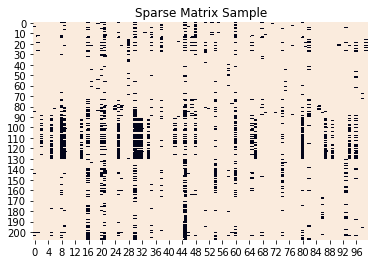

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0,
            vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

### Train and Test a Model

In [ ]:
# Model Design
clf1 = svm.SVC(gamma='scale')
clf2 = RandomForestClassifier(n_estimators=500, random_state=1)
clf3 = MultinomialNB(alpha=0.01)
clf4 = DecisionTreeClassifier(random_state=0, max_depth=500)

svc = SVC(probability=True, kernel='linear')
ada = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)
ada2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")
ada3 = AdaBoostClassifier()
rf = RandomForestClassifier(max_depth=100, n_estimators=100, max_features=10)
nb = naive_bayes.MultinomialNB(alpha=0.01)
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', class_weight='balanced', C=1500)
dt = DecisionTreeClassifier(max_depth=500)

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        # train classifier
        model = nb.fit(X_train, y_train)
        predicted = model.predict(X_test)
        predicted_prob = model.predict_proba(X_test)
        accr = metrics.accuracy_score(y_test, predicted)

        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accrs.append(accr)
        preds.append(predicted)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 2 Accuracy: 0.8333333333333334, Mean Accuracy: 0.8214285714285714
Iteração: 1 Fold: 3 Accuracy: 0.8333333333333334, Mean Accuracy: 0.8253968253968255
Iteração: 1 Fold: 4 Accuracy: 0.7619047619047619, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 5 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 6 Accuracy: 0.8809523809523809, Mean Accuracy: 0.8214285714285715
Iteração: 1 Fold: 7 Accuracy: 0.7380952380952381, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 8 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8065476190476191
Iteração: 1 Fold: 9 Accuracy: 0.8809523809523809, Mean Accuracy: 0.8148148148148149
Iteração: 1 Fold: 10 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8142857142857144
-------------------------------------------
Iteração: 2 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 2 Fold: 2 Accuracy: 0

In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.8142857142857143


### Evaluate

#### Plot metrics resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.75	      0.86	       0.8	      0.76	       0.9
Design Document     	       1.0	      0.33	       0.5	      0.56	      0.67
License             	      0.89	       1.0	      0.94	      0.93	      0.98
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Release Notes       	      0.89	       1.0	      0.94	      0.93	      0.98
Requirement Document	      0.67	      0.67	      0.67	      0.64	      0.82
Setup Files         	      0.83	      0.71	      0.77	      0.73	      0.84

Macro Average       	      0.86	       0.8	       0.8	      0.79	      0.89
Micro Average       	      0.85	      0.85	      0.85	      0.73	      0.91


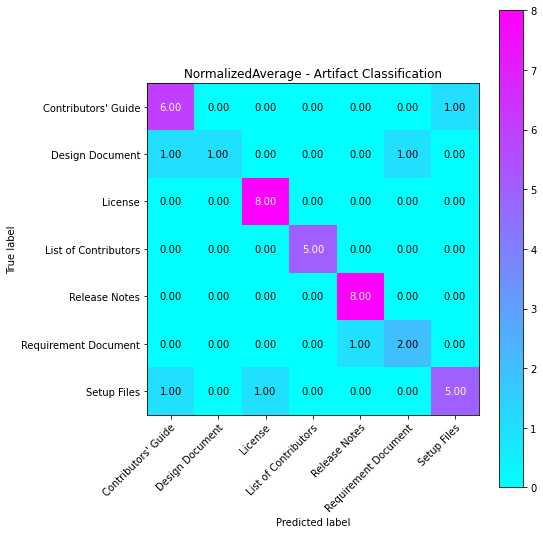

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## Create a Word2Vec

### Feature Engineer

In [15]:
corpus = df["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
# trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [16]:
len(trigrams_detector[lst_corpus])

208

### Fit Word2Vec

In [25]:
word_vect = gensim.models.word2vec.Word2Vec(trigrams_detector[lst_corpus], size=300,   
            window=8, min_count=1, sg=1, iter=30)

#Example
word = "data"
word_vect[word]

array([ 0.2444336 ,  0.40194488,  0.17418037, -0.08355833,  0.26592267,
        0.4467998 ,  0.5807698 , -0.06599496,  0.09550438,  0.24359393,
       -0.14667045, -0.17768763, -0.12168682,  0.01470297,  0.5144945 ,
        0.6000124 ,  0.37405333,  0.5710334 ,  0.12876378,  0.05045118,
       -0.31164685, -0.08049877, -0.06106451, -0.25004822,  0.17551504,
       -0.15569592, -0.20833269,  0.26055822, -0.15331194,  0.33880043,
        0.00248913, -0.23660046, -0.10559621,  0.10977   , -0.5020952 ,
        0.08182145, -0.19064023,  0.06741533,  0.3966032 ,  0.2180382 ,
        0.19426022,  0.37247354, -0.6969977 ,  0.84112483,  0.13903192,
        0.03983821,  0.02241284,  0.12141172, -0.22751147,  0.30093598,
        0.33700642,  0.13490398,  0.62883735,  0.11024776, -0.66167885,
        0.0463907 ,  0.13145399,  0.25012016, -0.15989126,  0.48639843,
       -0.5958709 , -0.58512306,  0.13790484,  0.1985675 ,  0.27271318,
       -0.02104278, -0.26608628, -0.06931411, -0.15234986,  0.21

In [27]:
# verifica a quantidade de vocábulos
len(word_vect.wv.vocab) # Vocabulary size

15251

### Save word2vec vector

In [21]:
from gensim.models import KeyedVectors

# word_vect.wv.save_word2vec_format('fit-word2vec', binary=False)

### Load fitted word2vec vector 

In [24]:
# word_vect = KeyedVectors.load_word2vec_format("fit-word2vec", binary=False)

ValueError: ignored

In [29]:
# Verifica se a palavra "upload" faz parte do vocábulo
# 'upload' in word_vect.vocab # Check if "upload" is in w2v vacabulary

### A Word and its Context (3D)

# word_vect.most_similar(word, topn=20)

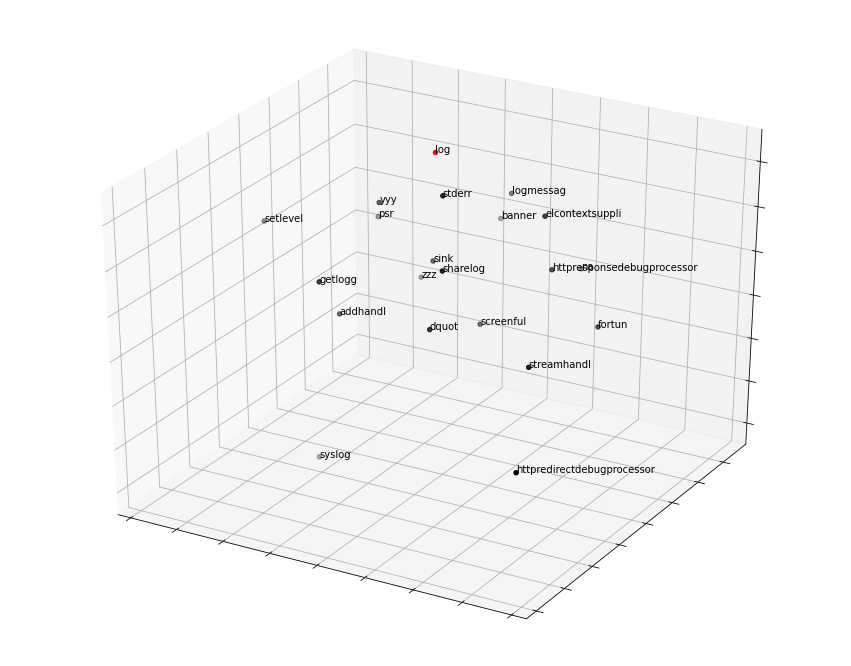

In [30]:
word = "log"
fig = plt.figure(figsize=(15,12))
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 word_vect.most_similar(word, topn=20)]
X = word_vect[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dataframe
dt_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dt_["input"] = 0
dt_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dt_[dt_["input"]==0]['x'], 
           dt_[dt_["input"]==0]['y'], 
           dt_[dt_["input"]==0]['z'], c="black")
ax.scatter(dt_[dt_["input"]==1]['x'], 
           dt_[dt_["input"]==1]['y'], 
           dt_[dt_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dt_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### Transform the Corpus into Padded Squences

In [31]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=50, padding="post", truncating="post")

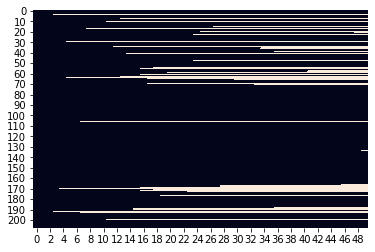

In [32]:
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Create the Matrix of Embedding

In [33]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  word_vect[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [34]:
#It can be navigated by word id, which can be obtained from the vocabulary.
word = "script"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 268 |idx
embeddings[idx]: (300,) |vector


In [35]:
embeddings.shape

(13564, 300)

### Deep Learning Model

In [38]:
from tensorflow.keras.constraints import max_norm
def fit_bert_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, epochs=1, batch_size=16):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    # print(dic_y_mapping)
    
    ## model
    if model is None:
        # input
        x_in = layers.Input(shape=(X_train.shape[1],))

        # embedding
        X = layers.Embedding(input_dim=embeddings.shape[0],  
                              output_dim=embeddings.shape[1], 
                              weights=[embeddings],
                              input_length=X_train.shape[1], trainable=True)(x_in)

        # 2 layers of bidirectional lstm
        X = layers.Bidirectional(layers.LSTM(180, return_sequences=True))(X)
        X = layers.Bidirectional(layers.LSTM(90))(X)
        X = layers.Dropout(0.3)(X)

        # ## final dense layers
        X = layers.Dense(32, activation='relu')(X)

        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(X)

        model = Model(x_in, y_out)
        ## compile
        model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='nadam', metrics=['accuracy'])
        # print(model.summary())
        
    ## train
    verbose = 1 if epochs > 1 else 2
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.2)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted

'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

### Define Target

In [37]:
y = df["Label"].values

### Train the Model

Epoch 1/10
17/17 [==============================] - 39s 197ms/step - loss: 1.8609 - accuracy: 0.2421 - val_loss: 1.4062 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 92ms/step - loss: 1.2439 - accuracy: 0.5467 - val_loss: 1.1009 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 93ms/step - loss: 0.6657 - accuracy: 0.8771 - val_loss: 0.8468 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 94ms/step - loss: 0.4524 - accuracy: 0.8454 - val_loss: 0.9839 - val_accuracy: 0.5882
Epoch 5/10
17/17 [==============================] - 2s 96ms/step - loss: 0.2325 - accuracy: 0.9521 - val_loss: 0.8797 - val_accuracy: 0.6471
Epoch 6/10
17/17 [==============================] - 2s 97ms/step - loss: 0.1360 - accuracy: 0.9811 - val_loss: 0.7489 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 95ms/step - loss: 0.0718 - accuracy: 0.9937 - val_loss: 0.6475 - val_accuracy: 0.7353
Epoch 8/10


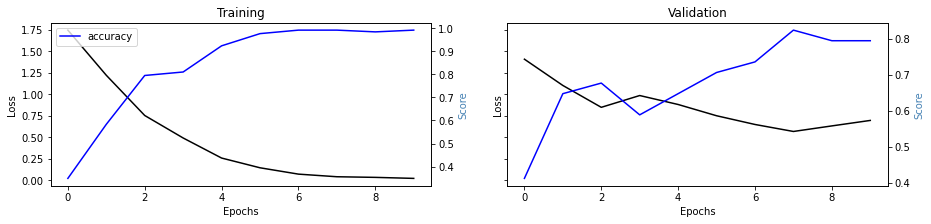

Iteração: 1 Fold: 1 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 219ms/step - loss: 1.7848 - accuracy: 0.3002 - val_loss: 1.3728 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 103ms/step - loss: 1.2288 - accuracy: 0.6194 - val_loss: 1.0323 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 100ms/step - loss: 0.6517 - accuracy: 0.8081 - val_loss: 0.9665 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 101ms/step - loss: 0.4490 - accuracy: 0.8791 - val_loss: 1.0068 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 101ms/step - loss: 0.1849 - accuracy: 0.9632 - val_loss: 0.7586 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 103ms/step - loss: 0.1656 - accuracy: 0.9517 - val_loss: 1.0000 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 100ms/st

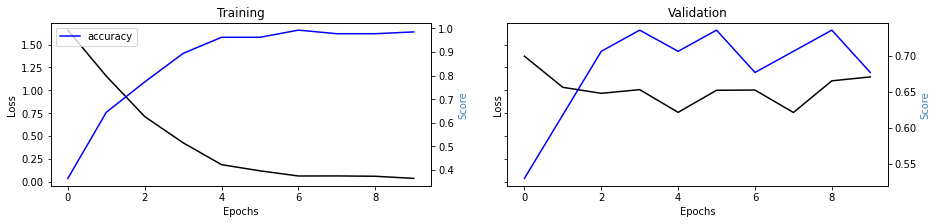

Iteração: 1 Fold: 2 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 10s 202ms/step - loss: 1.7853 - accuracy: 0.3412 - val_loss: 1.4071 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 101ms/step - loss: 1.1618 - accuracy: 0.6152 - val_loss: 1.6324 - val_accuracy: 0.4706
Epoch 3/10
17/17 [==============================] - 2s 100ms/step - loss: 0.8187 - accuracy: 0.7373 - val_loss: 1.1566 - val_accuracy: 0.5882
Epoch 4/10
17/17 [==============================] - 2s 102ms/step - loss: 0.3468 - accuracy: 0.8857 - val_loss: 1.1073 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 99ms/step - loss: 0.1467 - accuracy: 1.0000 - val_loss: 1.4008 - val_accuracy: 0.5882
Epoch 6/10
17/17 [==============================] - 2s 103ms/step - loss: 0.0872 - accuracy: 0.9788 - val_loss: 1.2371 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 101ms/ste

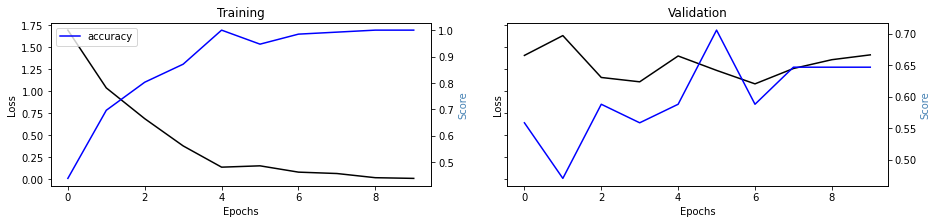

Iteração: 1 Fold: 3 Accuracy: 0.8333333333333334, Mean Accuracy: 0.8015873015873015
Epoch 1/10
17/17 [==============================] - 11s 196ms/step - loss: 1.8006 - accuracy: 0.2232 - val_loss: 1.4980 - val_accuracy: 0.3529
Epoch 2/10
17/17 [==============================] - 2s 99ms/step - loss: 1.1820 - accuracy: 0.5863 - val_loss: 1.1766 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 97ms/step - loss: 0.6884 - accuracy: 0.8399 - val_loss: 1.1824 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 99ms/step - loss: 0.3581 - accuracy: 0.8962 - val_loss: 1.5937 - val_accuracy: 0.5294
Epoch 5/10
17/17 [==============================] - 2s 96ms/step - loss: 0.3891 - accuracy: 0.9203 - val_loss: 0.9771 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 99ms/step - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.7650 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 101ms/step - 

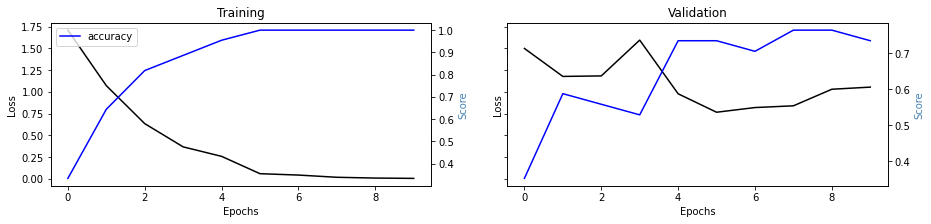

Iteração: 1 Fold: 4 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7797619047619048
Epoch 1/10
17/17 [==============================] - 11s 194ms/step - loss: 1.8641 - accuracy: 0.2963 - val_loss: 1.4442 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 100ms/step - loss: 1.1532 - accuracy: 0.6174 - val_loss: 1.1989 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 98ms/step - loss: 0.7075 - accuracy: 0.7465 - val_loss: 1.3515 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 100ms/step - loss: 0.3239 - accuracy: 0.9005 - val_loss: 1.0852 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 98ms/step - loss: 0.3147 - accuracy: 0.8895 - val_loss: 1.7670 - val_accuracy: 0.5000
Epoch 6/10
17/17 [==============================] - 2s 97ms/step - loss: 0.2405 - accuracy: 0.9288 - val_loss: 0.7967 - val_accuracy: 0.6471
Epoch 7/10
17/17 [==============================] - 2s 100ms/step 

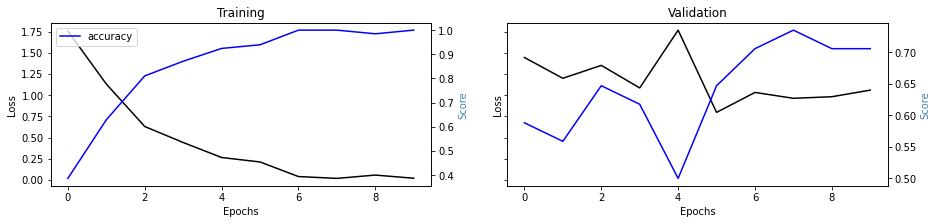

Iteração: 1 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7761904761904762
Epoch 1/10
17/17 [==============================] - 11s 242ms/step - loss: 1.8542 - accuracy: 0.2228 - val_loss: 1.3998 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 105ms/step - loss: 1.1476 - accuracy: 0.6451 - val_loss: 1.1773 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 105ms/step - loss: 0.6378 - accuracy: 0.8643 - val_loss: 1.1450 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 103ms/step - loss: 0.5079 - accuracy: 0.8793 - val_loss: 0.7134 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 104ms/step - loss: 0.2809 - accuracy: 0.9322 - val_loss: 0.6141 - val_accuracy: 0.8529
Epoch 6/10
17/17 [==============================] - 2s 104ms/step - loss: 0.0825 - accuracy: 0.9967 - val_loss: 0.7255 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 103ms/st

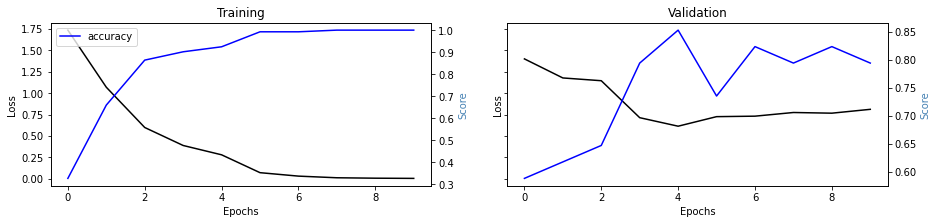

Iteração: 1 Fold: 6 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7777777777777778
Epoch 1/10
17/17 [==============================] - 10s 200ms/step - loss: 1.7784 - accuracy: 0.2644 - val_loss: 1.3873 - val_accuracy: 0.4412
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.1827 - accuracy: 0.6126 - val_loss: 0.9703 - val_accuracy: 0.7941
Epoch 3/10
17/17 [==============================] - 2s 106ms/step - loss: 0.8116 - accuracy: 0.8021 - val_loss: 0.8127 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 105ms/step - loss: 0.4014 - accuracy: 0.9082 - val_loss: 0.7288 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 103ms/step - loss: 0.1750 - accuracy: 0.9739 - val_loss: 0.4852 - val_accuracy: 0.8824
Epoch 6/10
17/17 [==============================] - 2s 104ms/step - loss: 0.0795 - accuracy: 0.9901 - val_loss: 0.5050 - val_accuracy: 0.8824
Epoch 7/10
17/17 [==============================] - 2s 106ms/st

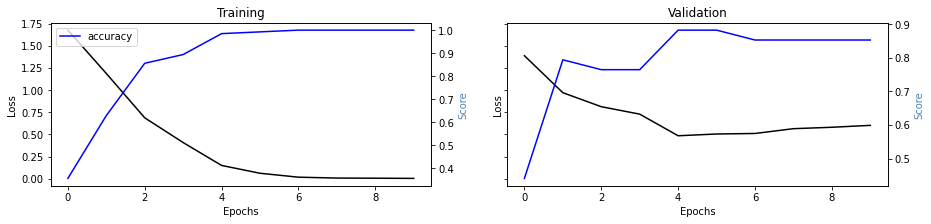

Iteração: 1 Fold: 7 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7687074829931974
Epoch 1/10
17/17 [==============================] - 11s 201ms/step - loss: 1.8190 - accuracy: 0.2564 - val_loss: 1.5491 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.2749 - accuracy: 0.5805 - val_loss: 1.9004 - val_accuracy: 0.3235
Epoch 3/10
17/17 [==============================] - 2s 106ms/step - loss: 0.5907 - accuracy: 0.8175 - val_loss: 1.4631 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.5238 - accuracy: 0.8721 - val_loss: 1.6463 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.1499 - accuracy: 0.9664 - val_loss: 2.3688 - val_accuracy: 0.4412
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1714 - accuracy: 0.9570 - val_loss: 1.2161 - val_accuracy: 0.6471
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

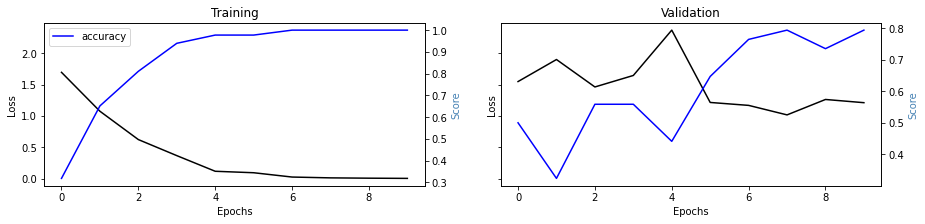

Iteração: 1 Fold: 8 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7767857142857143
Epoch 1/10
17/17 [==============================] - 11s 204ms/step - loss: 1.8743 - accuracy: 0.3160 - val_loss: 1.3657 - val_accuracy: 0.6471
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.2383 - accuracy: 0.6941 - val_loss: 0.9600 - val_accuracy: 0.7059
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.7745 - accuracy: 0.7681 - val_loss: 0.4953 - val_accuracy: 0.8529
Epoch 4/10
17/17 [==============================] - 2s 104ms/step - loss: 0.5430 - accuracy: 0.8134 - val_loss: 1.0310 - val_accuracy: 0.7059
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.4077 - accuracy: 0.8969 - val_loss: 0.3969 - val_accuracy: 0.9118
Epoch 6/10
17/17 [==============================] - 2s 105ms/step - loss: 0.1067 - accuracy: 0.9828 - val_loss: 0.3529 - val_accuracy: 0.8529
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

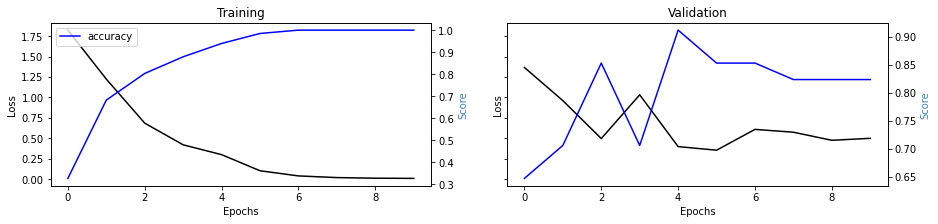

Iteração: 1 Fold: 9 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7804232804232805
Epoch 1/10
17/17 [==============================] - 10s 203ms/step - loss: 1.8598 - accuracy: 0.3218 - val_loss: 1.3955 - val_accuracy: 0.6471
Epoch 2/10
17/17 [==============================] - 2s 105ms/step - loss: 1.1835 - accuracy: 0.6748 - val_loss: 0.9170 - val_accuracy: 0.7647
Epoch 3/10
17/17 [==============================] - 2s 103ms/step - loss: 0.7869 - accuracy: 0.7851 - val_loss: 0.9206 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 106ms/step - loss: 0.4195 - accuracy: 0.9053 - val_loss: 0.7173 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 104ms/step - loss: 0.2216 - accuracy: 0.9563 - val_loss: 0.6696 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.2027 - accuracy: 0.9459 - val_loss: 1.1150 - val_accuracy: 0.6471
Epoch 7/10
17/17 [==============================] - 2s 105ms/st

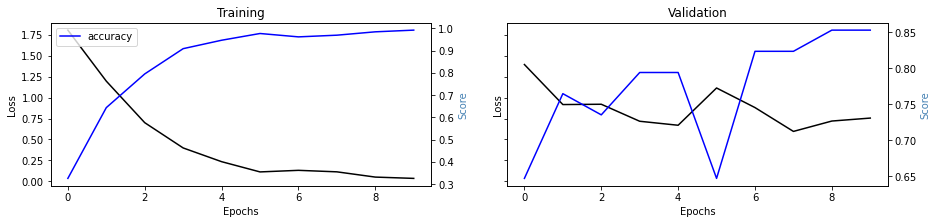

Iteração: 1 Fold: 10 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 10s 201ms/step - loss: 1.8731 - accuracy: 0.2674 - val_loss: 1.4697 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.2565 - accuracy: 0.6930 - val_loss: 1.0553 - val_accuracy: 0.7647
Epoch 3/10
17/17 [==============================] - 2s 103ms/step - loss: 0.7682 - accuracy: 0.8126 - val_loss: 1.2054 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 103ms/step - loss: 0.4854 - accuracy: 0.9017 - val_loss: 1.6722 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 101ms/step - loss: 0.4100 - accuracy: 0.9139 - val_loss: 0.5316 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 105ms/step - loss: 0.1533 - accuracy: 0.9571 - val_loss: 0.5430 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 101ms/s

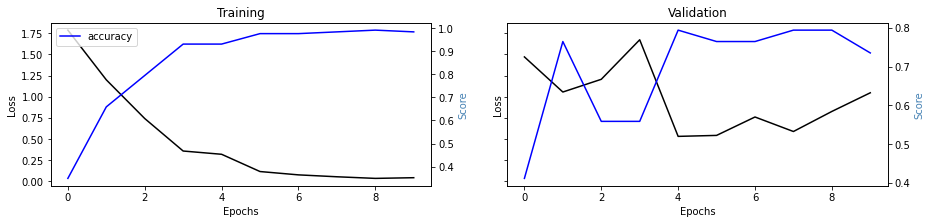

Iteração: 2 Fold: 1 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7380952380952381
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.8328 - accuracy: 0.2405 - val_loss: 1.3616 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.1742 - accuracy: 0.5792 - val_loss: 1.2874 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.5674 - accuracy: 0.8375 - val_loss: 0.8467 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 106ms/step - loss: 0.4769 - accuracy: 0.8584 - val_loss: 1.1555 - val_accuracy: 0.6471
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.3244 - accuracy: 0.9054 - val_loss: 0.8146 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1085 - accuracy: 0.9861 - val_loss: 0.6269 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

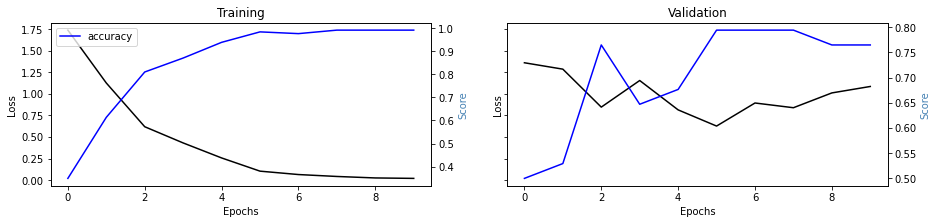

Iteração: 2 Fold: 2 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7619047619047619
Epoch 1/10
17/17 [==============================] - 11s 250ms/step - loss: 1.8097 - accuracy: 0.2878 - val_loss: 1.4949 - val_accuracy: 0.3529
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.2737 - accuracy: 0.5077 - val_loss: 1.1804 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.8276 - accuracy: 0.7440 - val_loss: 1.0190 - val_accuracy: 0.5882
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4529 - accuracy: 0.8503 - val_loss: 1.0560 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 104ms/step - loss: 0.3466 - accuracy: 0.9193 - val_loss: 1.0496 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.2251 - accuracy: 0.9618 - val_loss: 1.1082 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 108ms/st

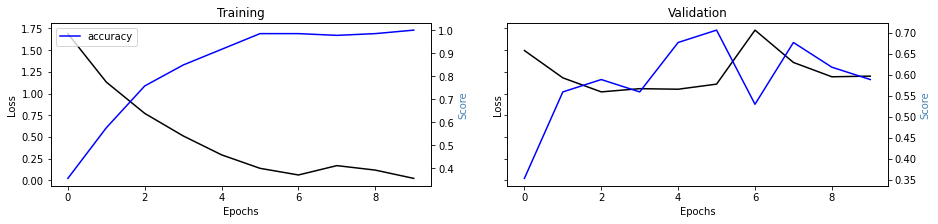

Iteração: 2 Fold: 3 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 10s 203ms/step - loss: 1.8630 - accuracy: 0.2211 - val_loss: 1.3735 - val_accuracy: 0.6471
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.3134 - accuracy: 0.5625 - val_loss: 1.3229 - val_accuracy: 0.3824
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.7285 - accuracy: 0.7495 - val_loss: 0.9661 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 107ms/step - loss: 0.2902 - accuracy: 0.9281 - val_loss: 1.1530 - val_accuracy: 0.5294
Epoch 5/10
17/17 [==============================] - 2s 111ms/step - loss: 0.3097 - accuracy: 0.9082 - val_loss: 0.9106 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.0781 - accuracy: 0.9953 - val_loss: 0.9828 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

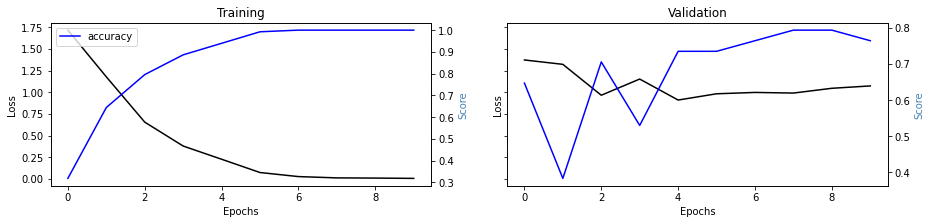

Iteração: 2 Fold: 4 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7738095238095238
Epoch 1/10
17/17 [==============================] - 11s 200ms/step - loss: 1.8034 - accuracy: 0.3500 - val_loss: 1.4773 - val_accuracy: 0.3824
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.1450 - accuracy: 0.6421 - val_loss: 1.1815 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.6656 - accuracy: 0.8354 - val_loss: 1.0804 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 107ms/step - loss: 0.2787 - accuracy: 0.9250 - val_loss: 1.2339 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 105ms/step - loss: 0.2154 - accuracy: 0.9270 - val_loss: 0.7684 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.0668 - accuracy: 0.9967 - val_loss: 0.9481 - val_accuracy: 0.6765
Epoch 7/10
17/17 [==============================] - 2s 106ms/st

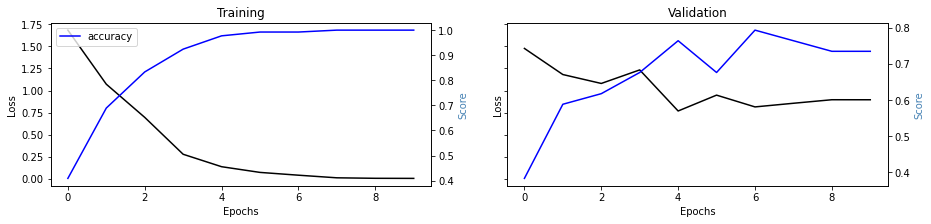

Iteração: 2 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7714285714285715
Epoch 1/10
17/17 [==============================] - 11s 204ms/step - loss: 1.8418 - accuracy: 0.2788 - val_loss: 1.6397 - val_accuracy: 0.3824
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.2772 - accuracy: 0.5649 - val_loss: 1.3083 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 102ms/step - loss: 0.7319 - accuracy: 0.7788 - val_loss: 1.0892 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 105ms/step - loss: 0.4970 - accuracy: 0.8753 - val_loss: 1.0317 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 105ms/step - loss: 0.1841 - accuracy: 0.9701 - val_loss: 0.8825 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.0666 - accuracy: 0.9940 - val_loss: 1.9641 - val_accuracy: 0.4118
Epoch 7/10
17/17 [==============================] - 2s 106ms/st

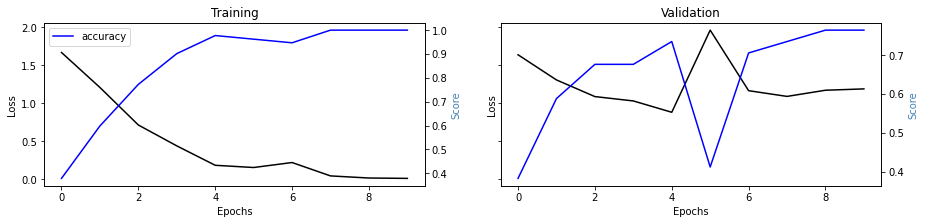

Iteração: 2 Fold: 6 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7658730158730158
Epoch 1/10
17/17 [==============================] - 11s 243ms/step - loss: 1.8445 - accuracy: 0.2513 - val_loss: 1.4174 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.2741 - accuracy: 0.4792 - val_loss: 0.9525 - val_accuracy: 0.7353
Epoch 3/10
17/17 [==============================] - 2s 105ms/step - loss: 0.8745 - accuracy: 0.7014 - val_loss: 0.8503 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 103ms/step - loss: 0.5663 - accuracy: 0.8857 - val_loss: 1.2824 - val_accuracy: 0.5882
Epoch 5/10
17/17 [==============================] - 2s 105ms/step - loss: 0.3602 - accuracy: 0.9035 - val_loss: 0.5945 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.1662 - accuracy: 0.9937 - val_loss: 0.7440 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

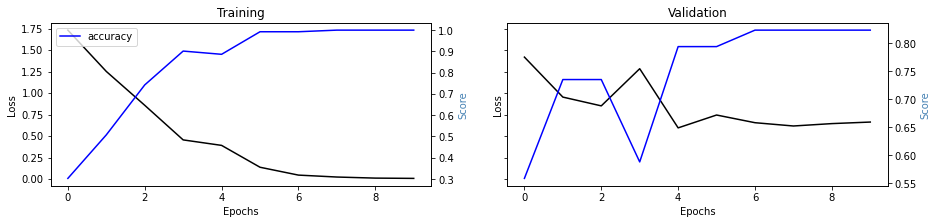

Iteração: 2 Fold: 7 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7619047619047619
Epoch 1/10
17/17 [==============================] - 10s 205ms/step - loss: 1.8456 - accuracy: 0.2372 - val_loss: 1.5703 - val_accuracy: 0.3529
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.1299 - accuracy: 0.5974 - val_loss: 1.2781 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.6367 - accuracy: 0.8319 - val_loss: 1.7282 - val_accuracy: 0.4412
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.5092 - accuracy: 0.8820 - val_loss: 1.3583 - val_accuracy: 0.5882
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1906 - accuracy: 0.9621 - val_loss: 1.4200 - val_accuracy: 0.5000
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.2675 - accuracy: 0.8892 - val_loss: 1.3047 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

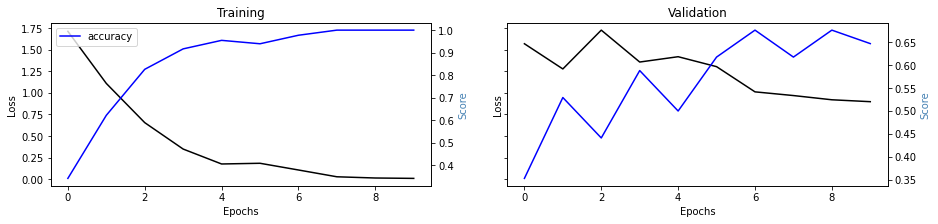

Iteração: 2 Fold: 8 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7648809523809523
Epoch 1/10
17/17 [==============================] - 12s 204ms/step - loss: 1.8367 - accuracy: 0.2898 - val_loss: 1.2978 - val_accuracy: 0.4412
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.2295 - accuracy: 0.5280 - val_loss: 0.8988 - val_accuracy: 0.7647
Epoch 3/10
17/17 [==============================] - 2s 106ms/step - loss: 0.6913 - accuracy: 0.8807 - val_loss: 0.5434 - val_accuracy: 0.7941
Epoch 4/10
17/17 [==============================] - 2s 106ms/step - loss: 0.3343 - accuracy: 0.9400 - val_loss: 0.5123 - val_accuracy: 0.8235
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1300 - accuracy: 0.9847 - val_loss: 0.3086 - val_accuracy: 0.8824
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0759 - accuracy: 0.9909 - val_loss: 0.2539 - val_accuracy: 0.9412
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

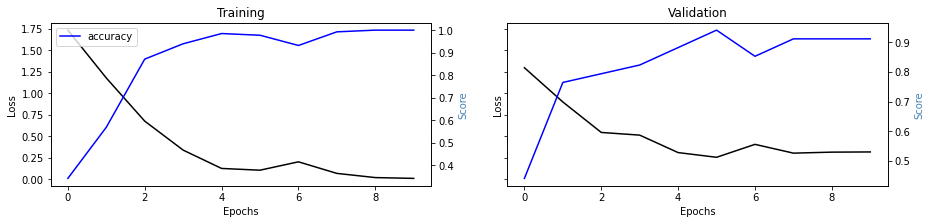

Iteração: 2 Fold: 9 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7645502645502645
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.7591 - accuracy: 0.3757 - val_loss: 1.1511 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.1670 - accuracy: 0.6510 - val_loss: 0.7016 - val_accuracy: 0.8235
Epoch 3/10
17/17 [==============================] - 2s 106ms/step - loss: 0.6513 - accuracy: 0.8196 - val_loss: 0.7692 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3940 - accuracy: 0.9180 - val_loss: 0.5584 - val_accuracy: 0.8529
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1864 - accuracy: 0.9552 - val_loss: 0.4890 - val_accuracy: 0.9118
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1466 - accuracy: 0.9578 - val_loss: 0.7990 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 104ms/st

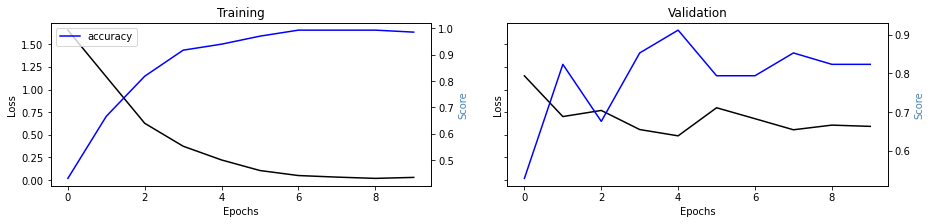

Iteração: 2 Fold: 10 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7714285714285714
Epoch 1/10
17/17 [==============================] - 10s 203ms/step - loss: 1.8025 - accuracy: 0.3090 - val_loss: 1.4231 - val_accuracy: 0.4412
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.2442 - accuracy: 0.5893 - val_loss: 1.2058 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.7491 - accuracy: 0.8155 - val_loss: 0.7572 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 104ms/step - loss: 0.3224 - accuracy: 0.9305 - val_loss: 0.6439 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1533 - accuracy: 0.9804 - val_loss: 1.0744 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1863 - accuracy: 0.9683 - val_loss: 0.7848 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 107ms/s

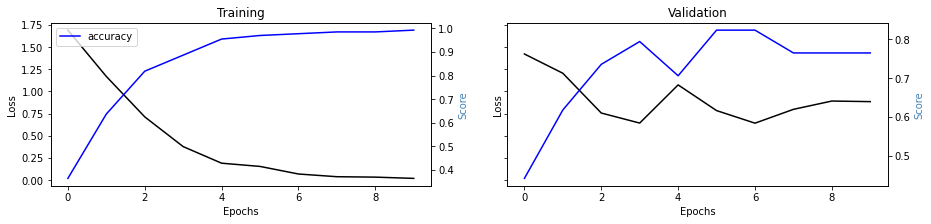

Iteração: 3 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8024 - accuracy: 0.3017 - val_loss: 1.7690 - val_accuracy: 0.2941
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.1972 - accuracy: 0.6614 - val_loss: 1.0724 - val_accuracy: 0.7647
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.6077 - accuracy: 0.8587 - val_loss: 0.7910 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3495 - accuracy: 0.9157 - val_loss: 2.0709 - val_accuracy: 0.5294
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.4512 - accuracy: 0.8774 - val_loss: 1.0506 - val_accuracy: 0.6471
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.1162 - accuracy: 0.9814 - val_loss: 1.0858 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

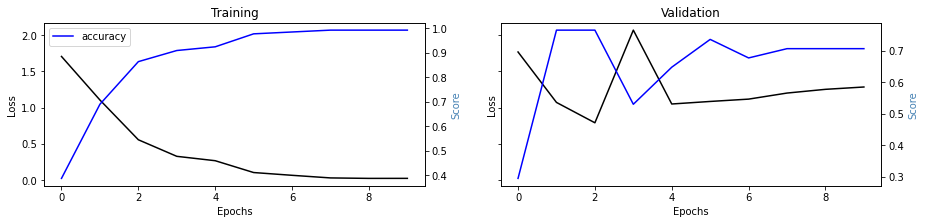

Iteração: 3 Fold: 2 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7976190476190477
Epoch 1/10
17/17 [==============================] - 12s 204ms/step - loss: 1.8363 - accuracy: 0.2850 - val_loss: 1.5396 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.1792 - accuracy: 0.6504 - val_loss: 1.1971 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.7723 - accuracy: 0.7880 - val_loss: 1.0747 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 107ms/step - loss: 0.4775 - accuracy: 0.8761 - val_loss: 1.4696 - val_accuracy: 0.5882
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.2511 - accuracy: 0.9465 - val_loss: 1.1721 - val_accuracy: 0.5882
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.0969 - accuracy: 0.9775 - val_loss: 1.3394 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 104ms/st

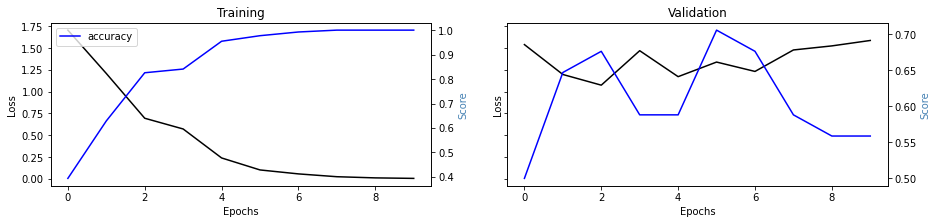

Iteração: 3 Fold: 3 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 249ms/step - loss: 1.7721 - accuracy: 0.3413 - val_loss: 1.4779 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 105ms/step - loss: 1.2325 - accuracy: 0.5629 - val_loss: 1.9197 - val_accuracy: 0.2059
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.8281 - accuracy: 0.7535 - val_loss: 1.4085 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3966 - accuracy: 0.9294 - val_loss: 1.1450 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3107 - accuracy: 0.9087 - val_loss: 1.1098 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.1178 - accuracy: 0.9694 - val_loss: 1.3332 - val_accuracy: 0.5882
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

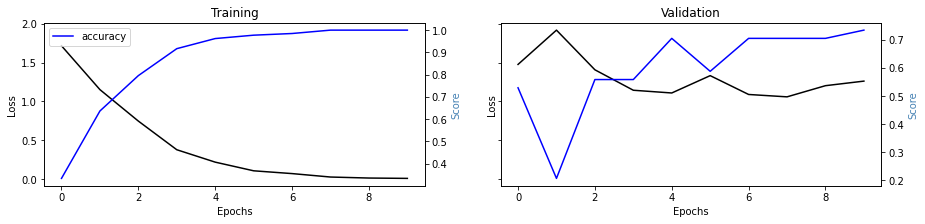

Iteração: 3 Fold: 4 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7678571428571429
Epoch 1/10
17/17 [==============================] - 10s 202ms/step - loss: 1.8146 - accuracy: 0.3152 - val_loss: 1.4668 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.1795 - accuracy: 0.6429 - val_loss: 1.1116 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.8133 - accuracy: 0.7954 - val_loss: 1.2653 - val_accuracy: 0.5294
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.4636 - accuracy: 0.8846 - val_loss: 0.8662 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1312 - accuracy: 0.9920 - val_loss: 0.8282 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0899 - accuracy: 0.9937 - val_loss: 0.8829 - val_accuracy: 0.6765
Epoch 7/10
17/17 [==============================] - 2s 108ms/st

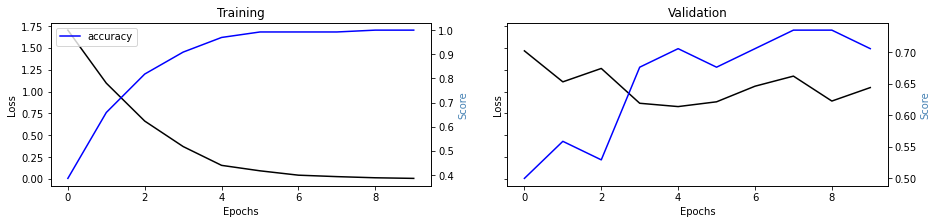

Iteração: 3 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7666666666666667
Epoch 1/10
17/17 [==============================] - 11s 204ms/step - loss: 1.8372 - accuracy: 0.2469 - val_loss: 1.5719 - val_accuracy: 0.4412
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.2151 - accuracy: 0.6259 - val_loss: 1.1935 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.7525 - accuracy: 0.7553 - val_loss: 0.9715 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3661 - accuracy: 0.9423 - val_loss: 0.6285 - val_accuracy: 0.8529
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1499 - accuracy: 0.9780 - val_loss: 0.6865 - val_accuracy: 0.8529
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.0582 - accuracy: 1.0000 - val_loss: 0.8443 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 105ms/st

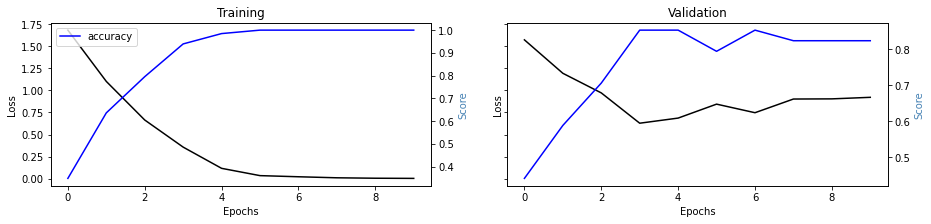

Iteração: 3 Fold: 6 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7698412698412699
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8173 - accuracy: 0.2351 - val_loss: 1.8225 - val_accuracy: 0.2941
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.3326 - accuracy: 0.5369 - val_loss: 1.0457 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.7345 - accuracy: 0.7886 - val_loss: 0.7454 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.3859 - accuracy: 0.8808 - val_loss: 0.5824 - val_accuracy: 0.8235
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.1827 - accuracy: 0.9780 - val_loss: 0.6779 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0460 - accuracy: 0.9897 - val_loss: 0.6087 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

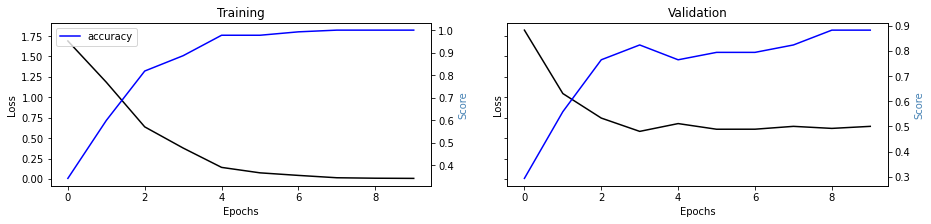

Iteração: 3 Fold: 7 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7687074829931974
Epoch 1/10
17/17 [==============================] - 10s 203ms/step - loss: 1.8409 - accuracy: 0.2595 - val_loss: 1.5971 - val_accuracy: 0.3235
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.1714 - accuracy: 0.6069 - val_loss: 1.2313 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.7357 - accuracy: 0.8050 - val_loss: 1.1170 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.2696 - accuracy: 0.9566 - val_loss: 1.4060 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.1864 - accuracy: 0.9717 - val_loss: 1.0909 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0372 - accuracy: 0.9992 - val_loss: 1.4112 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

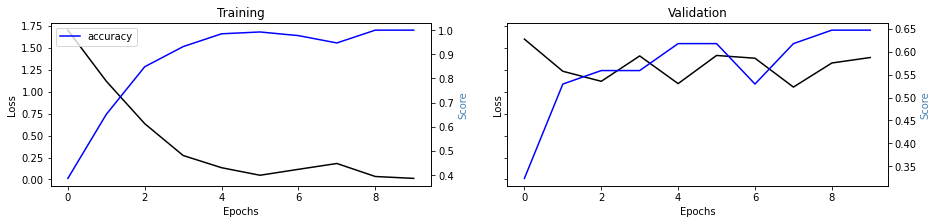

Iteração: 3 Fold: 8 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7797619047619048
Epoch 1/10
17/17 [==============================] - 10s 203ms/step - loss: 1.8473 - accuracy: 0.2919 - val_loss: 1.3712 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.3164 - accuracy: 0.6165 - val_loss: 0.9279 - val_accuracy: 0.7353
Epoch 3/10
17/17 [==============================] - 2s 106ms/step - loss: 0.7564 - accuracy: 0.8086 - val_loss: 0.6365 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 106ms/step - loss: 0.3926 - accuracy: 0.8933 - val_loss: 0.3440 - val_accuracy: 0.9118
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1469 - accuracy: 0.9953 - val_loss: 0.7345 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0737 - accuracy: 1.0000 - val_loss: 0.3002 - val_accuracy: 0.8824
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

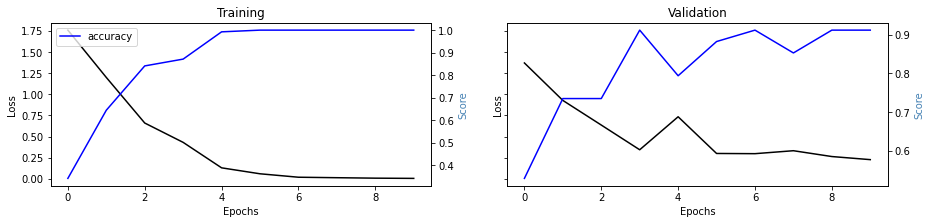

Iteração: 3 Fold: 9 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7777777777777778
Epoch 1/10
17/17 [==============================] - 12s 204ms/step - loss: 1.8327 - accuracy: 0.2483 - val_loss: 1.1626 - val_accuracy: 0.6765
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.2501 - accuracy: 0.6433 - val_loss: 0.8013 - val_accuracy: 0.7647
Epoch 3/10
17/17 [==============================] - 2s 105ms/step - loss: 0.7778 - accuracy: 0.7988 - val_loss: 0.8675 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4335 - accuracy: 0.8844 - val_loss: 1.1425 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.3366 - accuracy: 0.8862 - val_loss: 0.7401 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0994 - accuracy: 0.9901 - val_loss: 0.4492 - val_accuracy: 0.8824
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

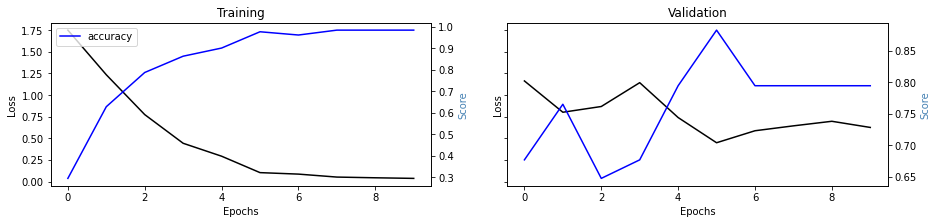

Iteração: 3 Fold: 10 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7785714285714286
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8280 - accuracy: 0.3004 - val_loss: 1.4102 - val_accuracy: 0.6471
Epoch 2/10
17/17 [==============================] - 2s 104ms/step - loss: 1.2444 - accuracy: 0.5747 - val_loss: 1.1865 - val_accuracy: 0.6765
Epoch 3/10
17/17 [==============================] - 2s 106ms/step - loss: 0.8071 - accuracy: 0.7714 - val_loss: 0.8243 - val_accuracy: 0.7941
Epoch 4/10
17/17 [==============================] - 2s 106ms/step - loss: 0.4891 - accuracy: 0.8965 - val_loss: 0.5749 - val_accuracy: 0.8235
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.2266 - accuracy: 0.9418 - val_loss: 0.5834 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 104ms/step - loss: 0.1024 - accuracy: 0.9944 - val_loss: 0.7386 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 108ms/s

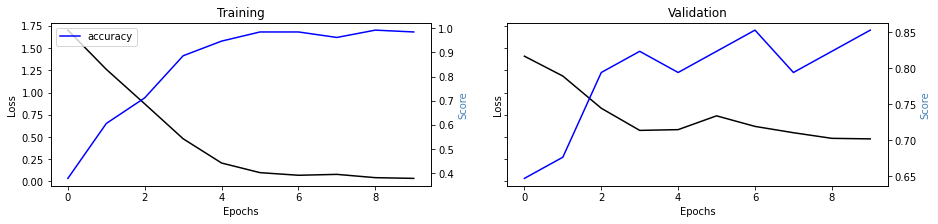

Iteração: 4 Fold: 1 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7619047619047619
Epoch 1/10
17/17 [==============================] - 10s 203ms/step - loss: 1.8223 - accuracy: 0.2493 - val_loss: 1.5224 - val_accuracy: 0.3824
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.1403 - accuracy: 0.6969 - val_loss: 1.1941 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 106ms/step - loss: 0.5903 - accuracy: 0.8509 - val_loss: 1.0797 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.3493 - accuracy: 0.8915 - val_loss: 0.6582 - val_accuracy: 0.7059
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.1967 - accuracy: 0.9681 - val_loss: 0.8191 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0943 - accuracy: 0.9907 - val_loss: 0.5737 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

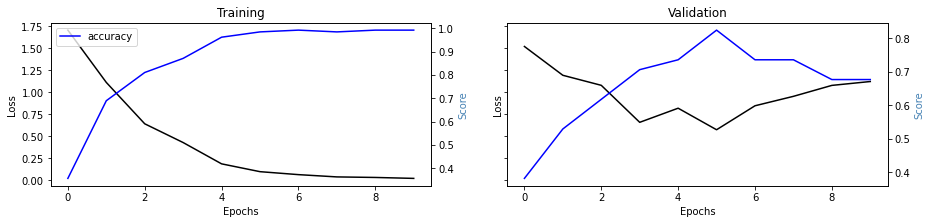

Iteração: 4 Fold: 2 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7380952380952381
Epoch 1/10
17/17 [==============================] - 10s 203ms/step - loss: 1.7969 - accuracy: 0.3004 - val_loss: 1.4194 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.2036 - accuracy: 0.6375 - val_loss: 1.1852 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.7023 - accuracy: 0.7816 - val_loss: 1.0355 - val_accuracy: 0.5294
Epoch 4/10
17/17 [==============================] - 2s 107ms/step - loss: 0.4694 - accuracy: 0.8470 - val_loss: 1.1330 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.2352 - accuracy: 0.9422 - val_loss: 1.2104 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.1196 - accuracy: 0.9672 - val_loss: 1.3023 - val_accuracy: 0.5882
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

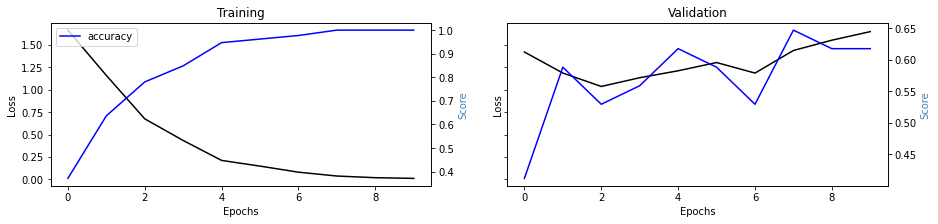

Iteração: 4 Fold: 3 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7777777777777778
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.8076 - accuracy: 0.3341 - val_loss: 1.9787 - val_accuracy: 0.1765
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.2740 - accuracy: 0.6246 - val_loss: 1.1459 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.6304 - accuracy: 0.8058 - val_loss: 1.3283 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3340 - accuracy: 0.9103 - val_loss: 0.9872 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3041 - accuracy: 0.8918 - val_loss: 0.8144 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1310 - accuracy: 0.9621 - val_loss: 0.6962 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

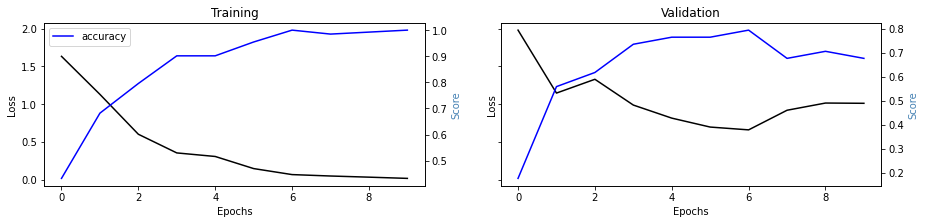

Iteração: 4 Fold: 4 Accuracy: 0.7142857142857143, Mean Accuracy: 0.761904761904762
Epoch 1/10
17/17 [==============================] - 11s 205ms/step - loss: 1.7570 - accuracy: 0.2890 - val_loss: 1.3857 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.1201 - accuracy: 0.6797 - val_loss: 1.0029 - val_accuracy: 0.7941
Epoch 3/10
17/17 [==============================] - 2s 104ms/step - loss: 0.6480 - accuracy: 0.8642 - val_loss: 0.9172 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4414 - accuracy: 0.9476 - val_loss: 0.9084 - val_accuracy: 0.7059
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1178 - accuracy: 0.9972 - val_loss: 0.8323 - val_accuracy: 0.6471
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.0442 - accuracy: 1.0000 - val_loss: 0.8693 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 107ms/ste

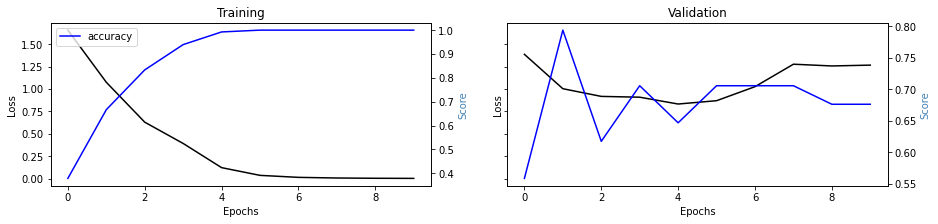

Iteração: 4 Fold: 5 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7666666666666667
Epoch 1/10
17/17 [==============================] - 10s 202ms/step - loss: 1.8665 - accuracy: 0.2628 - val_loss: 1.5200 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.1695 - accuracy: 0.6360 - val_loss: 1.2747 - val_accuracy: 0.7059
Epoch 3/10
17/17 [==============================] - 2s 105ms/step - loss: 0.7665 - accuracy: 0.7902 - val_loss: 1.3550 - val_accuracy: 0.5294
Epoch 4/10
17/17 [==============================] - 2s 106ms/step - loss: 0.4137 - accuracy: 0.8761 - val_loss: 0.8834 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.1959 - accuracy: 0.9619 - val_loss: 1.2743 - val_accuracy: 0.6471
Epoch 6/10
17/17 [==============================] - 2s 105ms/step - loss: 0.1303 - accuracy: 0.9694 - val_loss: 0.7804 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 108ms/st

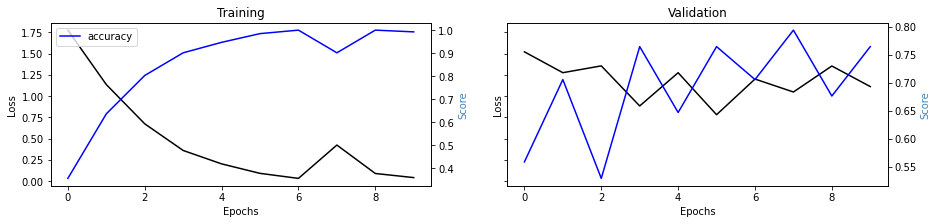

Iteração: 4 Fold: 6 Accuracy: 0.6904761904761905, Mean Accuracy: 0.753968253968254
Epoch 1/10
17/17 [==============================] - 10s 205ms/step - loss: 1.7892 - accuracy: 0.3177 - val_loss: 1.3414 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.2220 - accuracy: 0.6938 - val_loss: 1.1667 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.6823 - accuracy: 0.7804 - val_loss: 0.6563 - val_accuracy: 0.8235
Epoch 4/10
17/17 [==============================] - 2s 107ms/step - loss: 0.3845 - accuracy: 0.8997 - val_loss: 0.7389 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1480 - accuracy: 0.9933 - val_loss: 0.7035 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.0647 - accuracy: 0.9845 - val_loss: 0.5403 - val_accuracy: 0.8529
Epoch 7/10
17/17 [==============================] - 2s 108ms/ste

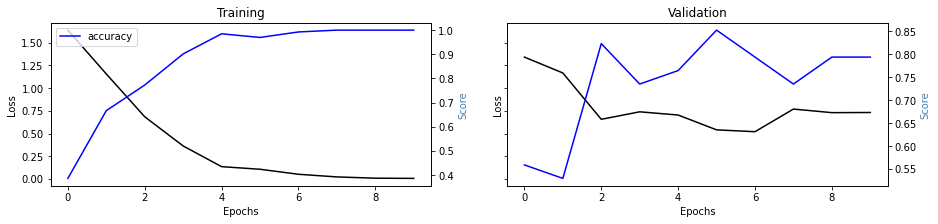

Iteração: 4 Fold: 7 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7482993197278912
Epoch 1/10
17/17 [==============================] - 11s 204ms/step - loss: 1.8076 - accuracy: 0.2597 - val_loss: 1.4339 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.1858 - accuracy: 0.6277 - val_loss: 1.2793 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.6199 - accuracy: 0.8394 - val_loss: 1.2955 - val_accuracy: 0.4706
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.4282 - accuracy: 0.8895 - val_loss: 1.1411 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1692 - accuracy: 0.9947 - val_loss: 2.4494 - val_accuracy: 0.4412
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.4281 - accuracy: 0.8948 - val_loss: 1.4862 - val_accuracy: 0.5588
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

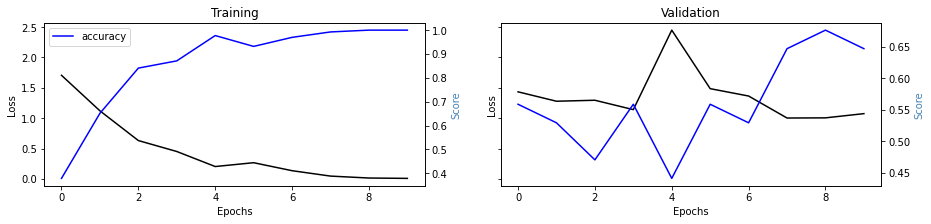

Iteração: 4 Fold: 8 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7470238095238095
Epoch 1/10
17/17 [==============================] - 11s 205ms/step - loss: 1.8839 - accuracy: 0.2366 - val_loss: 1.3375 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.4789 - accuracy: 0.4302 - val_loss: 1.1742 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 1.1121 - accuracy: 0.6845 - val_loss: 1.2614 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.6511 - accuracy: 0.8255 - val_loss: 0.4682 - val_accuracy: 0.8529
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.2515 - accuracy: 0.9483 - val_loss: 0.5629 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.1225 - accuracy: 0.9983 - val_loss: 0.3522 - val_accuracy: 0.9118
Epoch 7/10
17/17 [==============================] - 2s 108ms/st

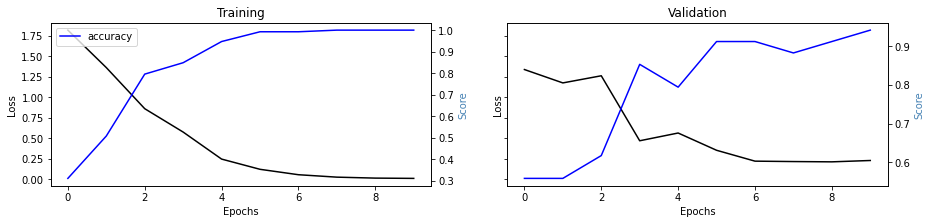

Iteração: 4 Fold: 9 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7486772486772487
Epoch 1/10
17/17 [==============================] - 10s 206ms/step - loss: 1.8884 - accuracy: 0.2090 - val_loss: 1.4569 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.3410 - accuracy: 0.6089 - val_loss: 1.0152 - val_accuracy: 0.6765
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.8365 - accuracy: 0.7275 - val_loss: 1.2861 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.5371 - accuracy: 0.8300 - val_loss: 0.7080 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1946 - accuracy: 0.9612 - val_loss: 0.4194 - val_accuracy: 0.9118
Epoch 6/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1740 - accuracy: 0.9510 - val_loss: 1.3332 - val_accuracy: 0.5588
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

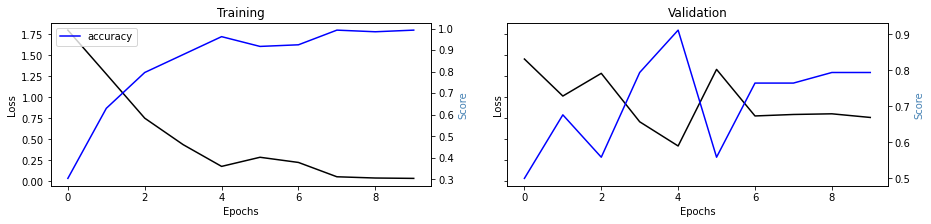

Iteração: 4 Fold: 10 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7595238095238095
Epoch 1/10
17/17 [==============================] - 11s 208ms/step - loss: 1.8532 - accuracy: 0.2574 - val_loss: 1.8280 - val_accuracy: 0.2647
Epoch 2/10
17/17 [==============================] - 2s 107ms/step - loss: 1.3143 - accuracy: 0.5690 - val_loss: 1.3313 - val_accuracy: 0.4706
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.8824 - accuracy: 0.7752 - val_loss: 0.9850 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 106ms/step - loss: 0.4204 - accuracy: 0.8942 - val_loss: 1.0215 - val_accuracy: 0.6471
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.2182 - accuracy: 0.9609 - val_loss: 0.8352 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.1784 - accuracy: 0.9693 - val_loss: 0.9614 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 108ms/s

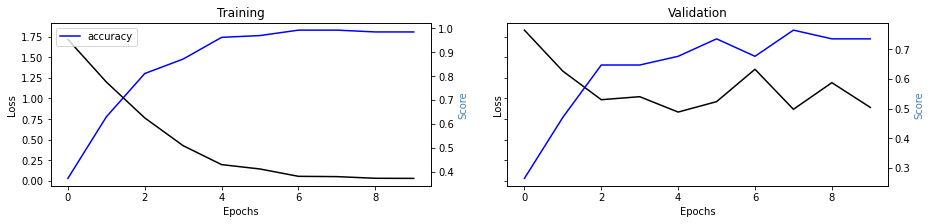

Iteração: 5 Fold: 1 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 205ms/step - loss: 1.8318 - accuracy: 0.3017 - val_loss: 1.5352 - val_accuracy: 0.3824
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.1670 - accuracy: 0.6318 - val_loss: 1.1828 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.8975 - accuracy: 0.7321 - val_loss: 0.9057 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3703 - accuracy: 0.9120 - val_loss: 1.5168 - val_accuracy: 0.4706
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4533 - accuracy: 0.8585 - val_loss: 0.7100 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.1279 - accuracy: 0.9937 - val_loss: 1.3520 - val_accuracy: 0.6765
Epoch 7/10
17/17 [==============================] - 2s 107ms/st

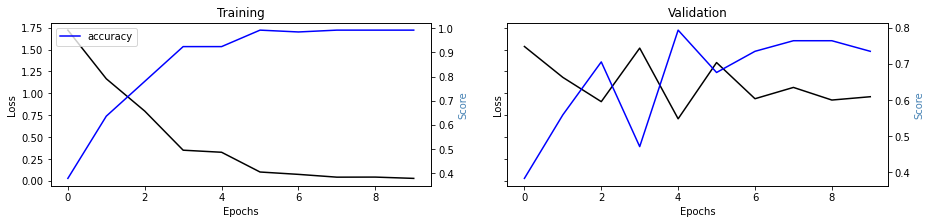

Iteração: 5 Fold: 2 Accuracy: 0.7142857142857143, Mean Accuracy: 0.75
Epoch 1/10
17/17 [==============================] - 11s 208ms/step - loss: 1.8057 - accuracy: 0.2439 - val_loss: 1.5771 - val_accuracy: 0.4412
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 1.0988 - accuracy: 0.6506 - val_loss: 1.2625 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 0.7139 - accuracy: 0.8149 - val_loss: 1.0889 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 107ms/step - loss: 0.3679 - accuracy: 0.9045 - val_loss: 1.0835 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.1804 - accuracy: 0.9829 - val_loss: 1.2078 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.1495 - accuracy: 0.9641 - val_loss: 1.3863 - val_accuracy: 0.5882
Epoch 7/10
17/17 [==============================] - 2s 106ms/step - loss: 0.0

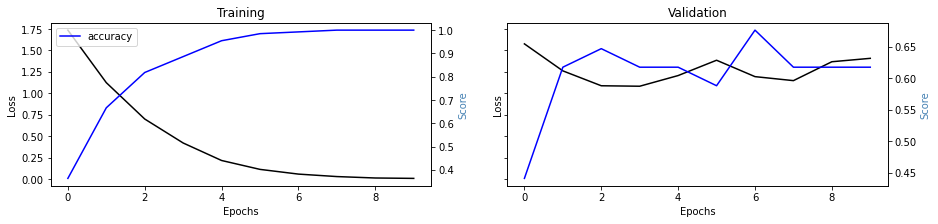

Iteração: 5 Fold: 3 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7698412698412698
Epoch 1/10
17/17 [==============================] - 10s 206ms/step - loss: 1.7987 - accuracy: 0.2903 - val_loss: 1.3816 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.2191 - accuracy: 0.5625 - val_loss: 0.9791 - val_accuracy: 0.7059
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.7999 - accuracy: 0.8094 - val_loss: 1.2824 - val_accuracy: 0.4706
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.5252 - accuracy: 0.8706 - val_loss: 0.6844 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.2263 - accuracy: 0.9149 - val_loss: 1.0009 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0856 - accuracy: 0.9934 - val_loss: 1.9478 - val_accuracy: 0.4412
Epoch 7/10
17/17 [==============================] - 2s 108ms/st

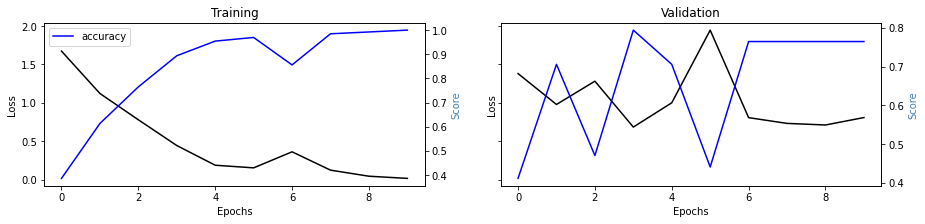

Iteração: 5 Fold: 4 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7678571428571428
Epoch 1/10
17/17 [==============================] - 10s 205ms/step - loss: 1.7761 - accuracy: 0.2703 - val_loss: 1.4302 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.2658 - accuracy: 0.6150 - val_loss: 1.5857 - val_accuracy: 0.5000
Epoch 3/10
17/17 [==============================] - 2s 104ms/step - loss: 0.7019 - accuracy: 0.7461 - val_loss: 1.1055 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3457 - accuracy: 0.9019 - val_loss: 1.3764 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 105ms/step - loss: 0.0861 - accuracy: 0.9992 - val_loss: 1.6278 - val_accuracy: 0.5000
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3462 - accuracy: 0.9151 - val_loss: 0.8161 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 106ms/st

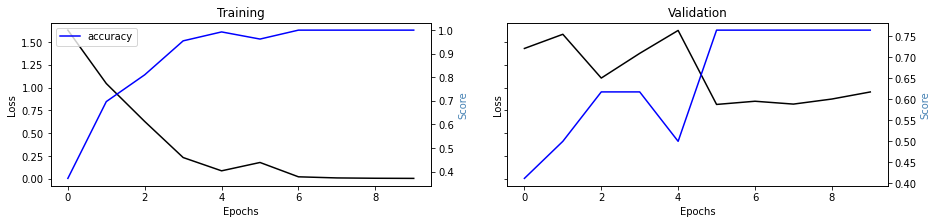

Iteração: 5 Fold: 5 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7571428571428571
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.8344 - accuracy: 0.3073 - val_loss: 1.4886 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.2018 - accuracy: 0.6514 - val_loss: 1.2528 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.6053 - accuracy: 0.8265 - val_loss: 1.1898 - val_accuracy: 0.5000
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.4110 - accuracy: 0.9238 - val_loss: 0.6271 - val_accuracy: 0.8529
Epoch 5/10
17/17 [==============================] - 2s 111ms/step - loss: 0.1438 - accuracy: 0.9798 - val_loss: 0.8633 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.0710 - accuracy: 0.9826 - val_loss: 0.7808 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

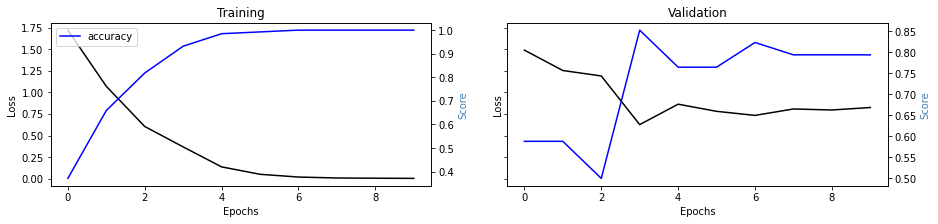

Iteração: 5 Fold: 6 Accuracy: 0.7380952380952381, Mean Accuracy: 0.753968253968254
Epoch 1/10
17/17 [==============================] - 11s 209ms/step - loss: 1.8217 - accuracy: 0.2982 - val_loss: 1.3747 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.1589 - accuracy: 0.5843 - val_loss: 1.5034 - val_accuracy: 0.4706
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.7822 - accuracy: 0.7873 - val_loss: 0.7775 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3612 - accuracy: 0.8996 - val_loss: 0.9053 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.2714 - accuracy: 0.9222 - val_loss: 0.9656 - val_accuracy: 0.6471
Epoch 6/10
17/17 [==============================] - 2s 111ms/step - loss: 0.2138 - accuracy: 0.9418 - val_loss: 0.8421 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 109ms/ste

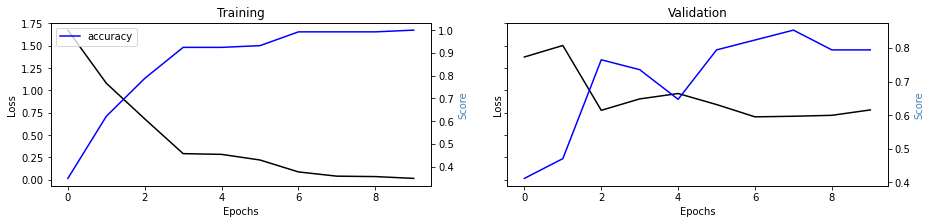

Iteração: 5 Fold: 7 Accuracy: 0.6428571428571429, Mean Accuracy: 0.7380952380952381
Epoch 1/10
17/17 [==============================] - 10s 202ms/step - loss: 1.7872 - accuracy: 0.3370 - val_loss: 1.8170 - val_accuracy: 0.2353
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.2340 - accuracy: 0.6496 - val_loss: 1.5102 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.5831 - accuracy: 0.8525 - val_loss: 2.2078 - val_accuracy: 0.4412
Epoch 4/10
17/17 [==============================] - 2s 107ms/step - loss: 0.3050 - accuracy: 0.9559 - val_loss: 1.2177 - val_accuracy: 0.5294
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.2745 - accuracy: 0.9188 - val_loss: 1.6535 - val_accuracy: 0.5294
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0873 - accuracy: 0.9729 - val_loss: 1.2707 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

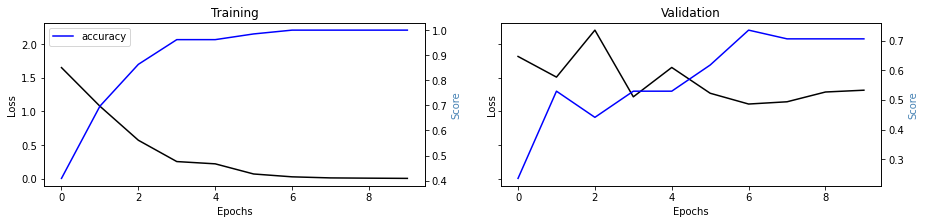

Iteração: 5 Fold: 8 Accuracy: 0.8333333333333334, Mean Accuracy: 0.75
Epoch 1/10
17/17 [==============================] - 10s 210ms/step - loss: 1.9188 - accuracy: 0.1644 - val_loss: 1.5040 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.4101 - accuracy: 0.5411 - val_loss: 0.7761 - val_accuracy: 0.8235
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.7832 - accuracy: 0.8112 - val_loss: 0.7767 - val_accuracy: 0.7941
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4123 - accuracy: 0.9670 - val_loss: 0.6702 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.2022 - accuracy: 0.9789 - val_loss: 0.3022 - val_accuracy: 0.8824
Epoch 6/10
17/17 [==============================] - 2s 111ms/step - loss: 0.0840 - accuracy: 0.9897 - val_loss: 0.3666 - val_accuracy: 0.8529
Epoch 7/10
17/17 [==============================] - 2s 113ms/step - loss: 0.0

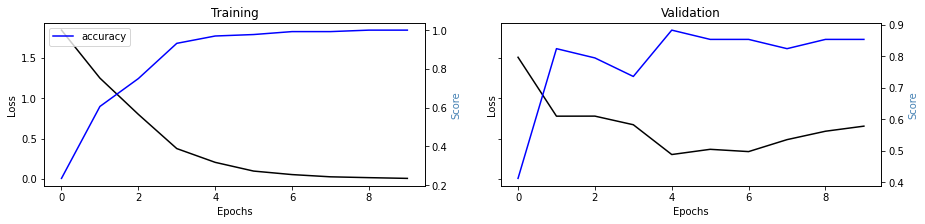

Iteração: 5 Fold: 9 Accuracy: 0.7857142857142857, Mean Accuracy: 0.753968253968254
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.8875 - accuracy: 0.2800 - val_loss: 1.2331 - val_accuracy: 0.7353
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.1931 - accuracy: 0.5774 - val_loss: 1.1213 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.7277 - accuracy: 0.7837 - val_loss: 0.6702 - val_accuracy: 0.8529
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3098 - accuracy: 0.9454 - val_loss: 0.8219 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1970 - accuracy: 0.9261 - val_loss: 0.6682 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0674 - accuracy: 0.9943 - val_loss: 0.4094 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 111ms/ste

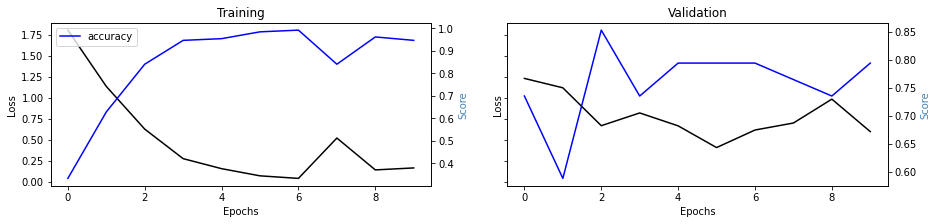

Iteração: 5 Fold: 10 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7642857142857142
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.8241 - accuracy: 0.2561 - val_loss: 1.5310 - val_accuracy: 0.3235
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.3218 - accuracy: 0.4717 - val_loss: 1.3769 - val_accuracy: 0.4412
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.8706 - accuracy: 0.6887 - val_loss: 1.2933 - val_accuracy: 0.5000
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.6494 - accuracy: 0.8036 - val_loss: 0.5352 - val_accuracy: 0.8235
Epoch 5/10
17/17 [==============================] - 2s 111ms/step - loss: 0.2019 - accuracy: 0.9703 - val_loss: 0.5402 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0864 - accuracy: 0.9972 - val_loss: 0.7677 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 110ms/s

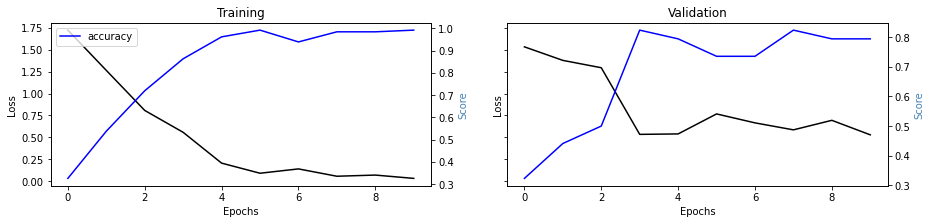

Iteração: 6 Fold: 1 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7619047619047619
Epoch 1/10
17/17 [==============================] - 10s 205ms/step - loss: 1.8583 - accuracy: 0.2408 - val_loss: 1.5450 - val_accuracy: 0.3824
Epoch 2/10
17/17 [==============================] - 2s 108ms/step - loss: 1.1518 - accuracy: 0.6464 - val_loss: 1.1320 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.6221 - accuracy: 0.8214 - val_loss: 1.1222 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4373 - accuracy: 0.8214 - val_loss: 1.4558 - val_accuracy: 0.4412
Epoch 5/10
17/17 [==============================] - 2s 107ms/step - loss: 0.3413 - accuracy: 0.8898 - val_loss: 1.1623 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.1066 - accuracy: 0.9694 - val_loss: 0.8601 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 108ms/st

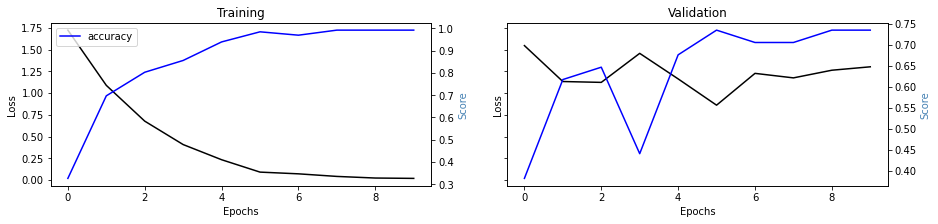

Iteração: 6 Fold: 2 Accuracy: 0.7380952380952381, Mean Accuracy: 0.75
Epoch 1/10
17/17 [==============================] - 10s 207ms/step - loss: 1.8432 - accuracy: 0.2737 - val_loss: 1.8071 - val_accuracy: 0.2647
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.3507 - accuracy: 0.5634 - val_loss: 1.4505 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.8804 - accuracy: 0.7734 - val_loss: 1.0318 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 112ms/step - loss: 0.3256 - accuracy: 0.9349 - val_loss: 1.3705 - val_accuracy: 0.6471
Epoch 5/10
17/17 [==============================] - 2s 111ms/step - loss: 0.2021 - accuracy: 0.9569 - val_loss: 1.1062 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 111ms/step - loss: 0.0932 - accuracy: 0.9953 - val_loss: 1.7757 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1

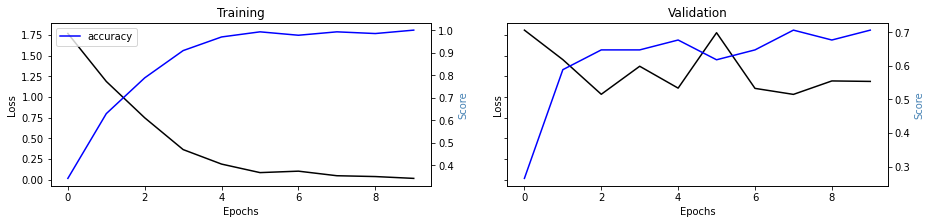

Iteração: 6 Fold: 3 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7777777777777778
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8531 - accuracy: 0.2367 - val_loss: 1.4395 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.2021 - accuracy: 0.6468 - val_loss: 1.1856 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.9472 - accuracy: 0.6879 - val_loss: 0.9866 - val_accuracy: 0.5882
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.4815 - accuracy: 0.8381 - val_loss: 0.8698 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.2802 - accuracy: 0.9518 - val_loss: 0.7089 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1498 - accuracy: 0.9733 - val_loss: 0.7447 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

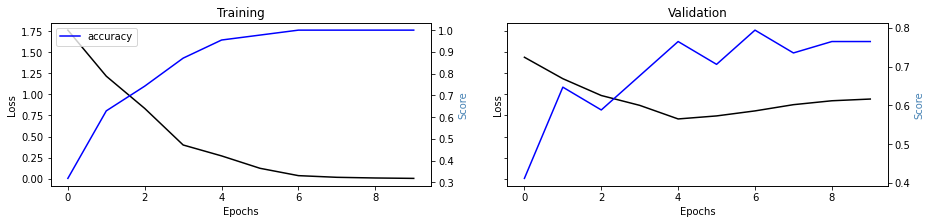

Iteração: 6 Fold: 4 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7916666666666667
Epoch 1/10
17/17 [==============================] - 11s 210ms/step - loss: 1.7254 - accuracy: 0.3371 - val_loss: 1.5754 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.2573 - accuracy: 0.6819 - val_loss: 1.1512 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.6444 - accuracy: 0.8201 - val_loss: 1.5815 - val_accuracy: 0.4118
Epoch 4/10
17/17 [==============================] - 2s 111ms/step - loss: 0.4590 - accuracy: 0.8925 - val_loss: 0.7687 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 111ms/step - loss: 0.0837 - accuracy: 0.9907 - val_loss: 0.7680 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.0516 - accuracy: 0.9915 - val_loss: 0.9494 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 111ms/st

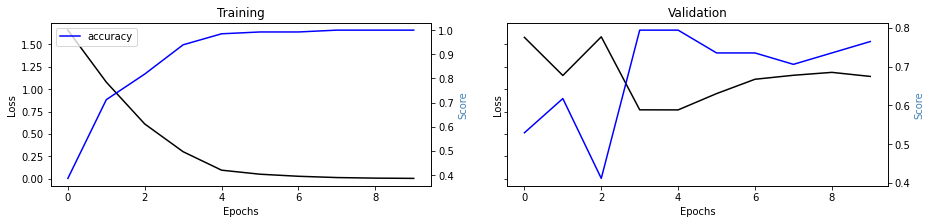

Iteração: 6 Fold: 5 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7904761904761906
Epoch 1/10
17/17 [==============================] - 10s 206ms/step - loss: 1.8715 - accuracy: 0.2178 - val_loss: 1.6175 - val_accuracy: 0.3824
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.1505 - accuracy: 0.5694 - val_loss: 1.3369 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 108ms/step - loss: 0.7270 - accuracy: 0.7938 - val_loss: 1.5835 - val_accuracy: 0.5000
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.4193 - accuracy: 0.8683 - val_loss: 0.6894 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.2704 - accuracy: 0.9508 - val_loss: 0.7428 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 106ms/step - loss: 0.0602 - accuracy: 0.9915 - val_loss: 0.8362 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

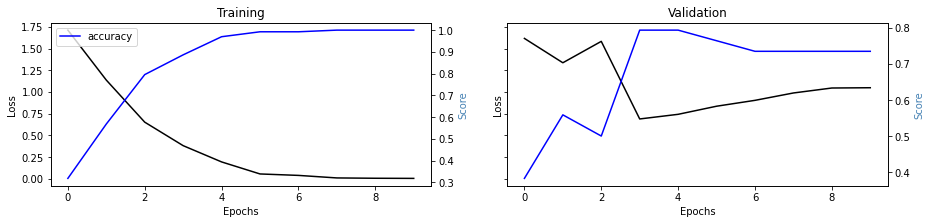

Iteração: 6 Fold: 6 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7976190476190476
Epoch 1/10
17/17 [==============================] - 10s 205ms/step - loss: 1.8644 - accuracy: 0.2110 - val_loss: 1.3228 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.3024 - accuracy: 0.5662 - val_loss: 1.0155 - val_accuracy: 0.8235
Epoch 3/10
17/17 [==============================] - 2s 111ms/step - loss: 0.8297 - accuracy: 0.7751 - val_loss: 0.8894 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.5176 - accuracy: 0.8307 - val_loss: 0.5252 - val_accuracy: 0.8529
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.2003 - accuracy: 0.9739 - val_loss: 0.7452 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0900 - accuracy: 0.9833 - val_loss: 0.6039 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

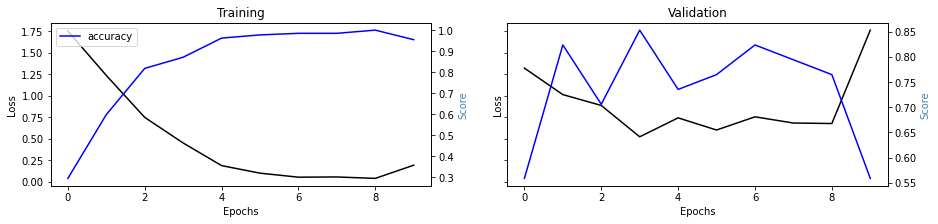

Iteração: 6 Fold: 7 Accuracy: 0.5714285714285714, Mean Accuracy: 0.7653061224489796
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.8126 - accuracy: 0.2777 - val_loss: 1.4471 - val_accuracy: 0.4706
Epoch 2/10
17/17 [==============================] - 2s 112ms/step - loss: 1.1746 - accuracy: 0.6000 - val_loss: 1.3533 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.6353 - accuracy: 0.8098 - val_loss: 1.5532 - val_accuracy: 0.5000
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4566 - accuracy: 0.8891 - val_loss: 0.9690 - val_accuracy: 0.5294
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3140 - accuracy: 0.9400 - val_loss: 0.9565 - val_accuracy: 0.5882
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0759 - accuracy: 0.9953 - val_loss: 1.2869 - val_accuracy: 0.5882
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

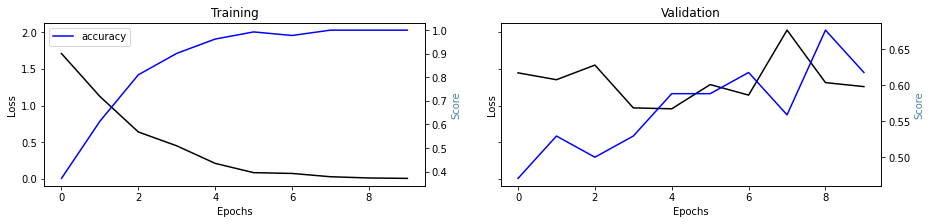

Iteração: 6 Fold: 8 Accuracy: 0.9047619047619048, Mean Accuracy: 0.7827380952380952
Epoch 1/10
17/17 [==============================] - 11s 208ms/step - loss: 1.8542 - accuracy: 0.2404 - val_loss: 1.2363 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 112ms/step - loss: 1.2985 - accuracy: 0.5475 - val_loss: 1.5125 - val_accuracy: 0.4706
Epoch 3/10
17/17 [==============================] - 2s 111ms/step - loss: 1.0232 - accuracy: 0.6958 - val_loss: 1.0955 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.5195 - accuracy: 0.8976 - val_loss: 0.8006 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.2505 - accuracy: 0.9757 - val_loss: 0.5768 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1033 - accuracy: 0.9793 - val_loss: 0.3583 - val_accuracy: 0.9118
Epoch 7/10
17/17 [==============================] - 2s 113ms/st

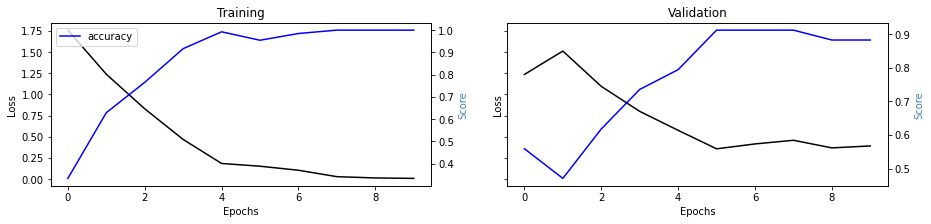

Iteração: 6 Fold: 9 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7804232804232805
Epoch 1/10
17/17 [==============================] - 10s 209ms/step - loss: 1.8818 - accuracy: 0.2447 - val_loss: 1.7646 - val_accuracy: 0.2059
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.3431 - accuracy: 0.5286 - val_loss: 1.1606 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 111ms/step - loss: 0.9216 - accuracy: 0.7623 - val_loss: 1.2493 - val_accuracy: 0.5882
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.4027 - accuracy: 0.8863 - val_loss: 0.7005 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.2721 - accuracy: 0.9051 - val_loss: 0.5268 - val_accuracy: 0.8235
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1855 - accuracy: 0.9754 - val_loss: 0.6048 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 108ms/st

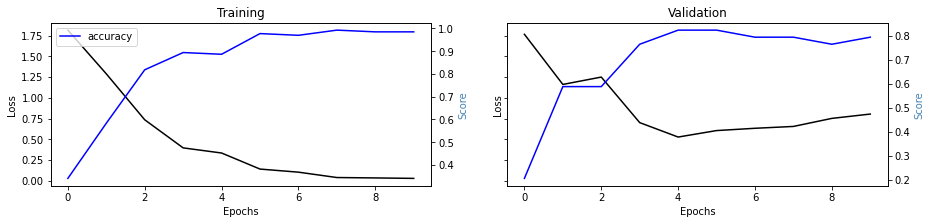

Iteração: 6 Fold: 10 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 10s 207ms/step - loss: 1.8694 - accuracy: 0.2333 - val_loss: 1.5354 - val_accuracy: 0.4706
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.3644 - accuracy: 0.5814 - val_loss: 1.1230 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 112ms/step - loss: 0.8711 - accuracy: 0.7227 - val_loss: 0.8571 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3887 - accuracy: 0.9013 - val_loss: 1.2511 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 111ms/step - loss: 0.1646 - accuracy: 0.9803 - val_loss: 0.8798 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1787 - accuracy: 0.9710 - val_loss: 0.8479 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 111ms/s

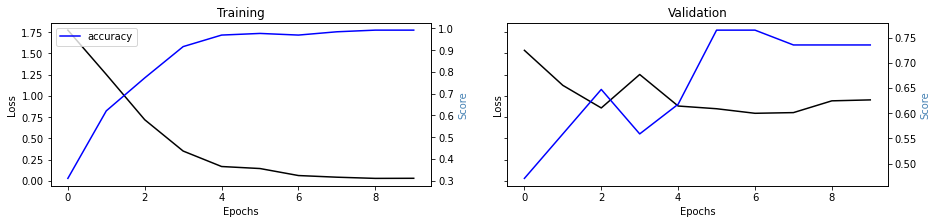

Iteração: 7 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8293 - accuracy: 0.2813 - val_loss: 1.3698 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.2497 - accuracy: 0.5577 - val_loss: 0.9593 - val_accuracy: 0.6765
Epoch 3/10
17/17 [==============================] - 2s 111ms/step - loss: 0.8119 - accuracy: 0.7743 - val_loss: 1.0291 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 112ms/step - loss: 0.5248 - accuracy: 0.8086 - val_loss: 1.5935 - val_accuracy: 0.5294
Epoch 5/10
17/17 [==============================] - 2s 106ms/step - loss: 0.5091 - accuracy: 0.8731 - val_loss: 0.6597 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.1197 - accuracy: 0.9946 - val_loss: 0.9875 - val_accuracy: 0.6765
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

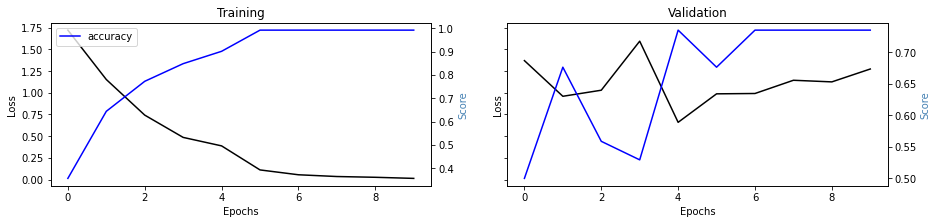

Iteração: 7 Fold: 2 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 209ms/step - loss: 1.7826 - accuracy: 0.3395 - val_loss: 1.5137 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.2239 - accuracy: 0.5603 - val_loss: 2.2885 - val_accuracy: 0.3529
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 1.0610 - accuracy: 0.6825 - val_loss: 1.1060 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.5896 - accuracy: 0.7837 - val_loss: 0.9050 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.2150 - accuracy: 0.9293 - val_loss: 0.9852 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.1915 - accuracy: 0.9444 - val_loss: 1.0879 - val_accuracy: 0.5882
Epoch 7/10
17/17 [==============================] - 2s 109ms/st

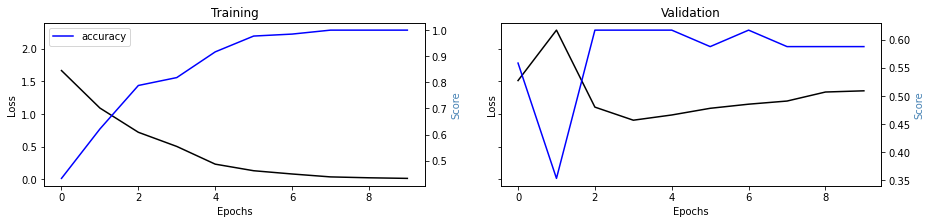

Iteração: 7 Fold: 3 Accuracy: 0.8333333333333334, Mean Accuracy: 0.8015873015873015
Epoch 1/10
17/17 [==============================] - 10s 204ms/step - loss: 1.7807 - accuracy: 0.3208 - val_loss: 1.3668 - val_accuracy: 0.3529
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.2412 - accuracy: 0.5896 - val_loss: 1.0978 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.7608 - accuracy: 0.7807 - val_loss: 0.7205 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 113ms/step - loss: 0.3889 - accuracy: 0.9024 - val_loss: 0.8986 - val_accuracy: 0.7059
Epoch 5/10
17/17 [==============================] - 2s 111ms/step - loss: 0.1985 - accuracy: 0.9607 - val_loss: 0.8687 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.0750 - accuracy: 0.9978 - val_loss: 0.6489 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

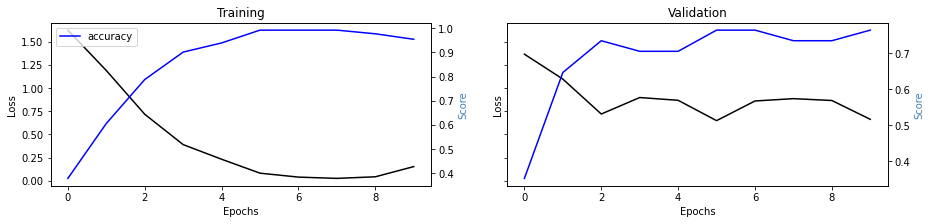

Iteração: 7 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7976190476190476
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8354 - accuracy: 0.1983 - val_loss: 1.4765 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 112ms/step - loss: 1.1852 - accuracy: 0.6782 - val_loss: 1.2003 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.7008 - accuracy: 0.7308 - val_loss: 1.3247 - val_accuracy: 0.5294
Epoch 4/10
17/17 [==============================] - 2s 111ms/step - loss: 0.3280 - accuracy: 0.9058 - val_loss: 1.2187 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1006 - accuracy: 0.9876 - val_loss: 1.4696 - val_accuracy: 0.5588
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.2653 - accuracy: 0.8954 - val_loss: 1.0785 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 114ms/st

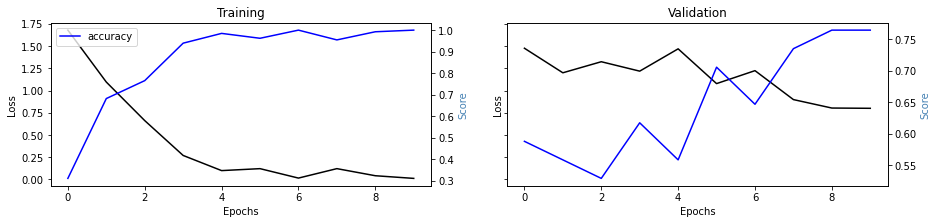

Iteração: 7 Fold: 5 Accuracy: 0.7142857142857143, Mean Accuracy: 0.780952380952381
Epoch 1/10
17/17 [==============================] - 11s 213ms/step - loss: 1.8481 - accuracy: 0.2312 - val_loss: 1.4905 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.1289 - accuracy: 0.6402 - val_loss: 1.2028 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 0.7566 - accuracy: 0.7463 - val_loss: 0.9146 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 109ms/step - loss: 0.5362 - accuracy: 0.8284 - val_loss: 0.7845 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1957 - accuracy: 0.9516 - val_loss: 0.6586 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.1395 - accuracy: 0.9781 - val_loss: 0.6780 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 113ms/ste

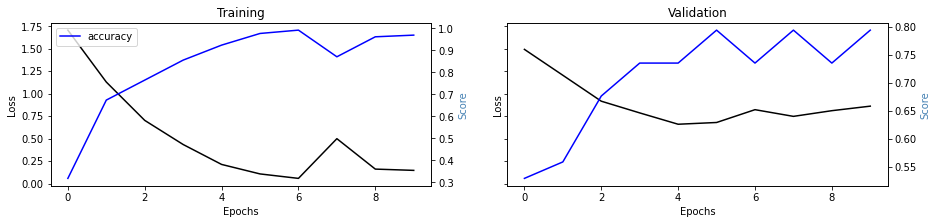

Iteração: 7 Fold: 6 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7698412698412698
Epoch 1/10
17/17 [==============================] - 11s 208ms/step - loss: 1.7628 - accuracy: 0.3073 - val_loss: 1.2347 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.0531 - accuracy: 0.6730 - val_loss: 0.7837 - val_accuracy: 0.7941
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.6517 - accuracy: 0.8278 - val_loss: 0.8150 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 111ms/step - loss: 0.3541 - accuracy: 0.9579 - val_loss: 0.5520 - val_accuracy: 0.8529
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1609 - accuracy: 0.9783 - val_loss: 0.6312 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0920 - accuracy: 0.9687 - val_loss: 0.6803 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 114ms/st

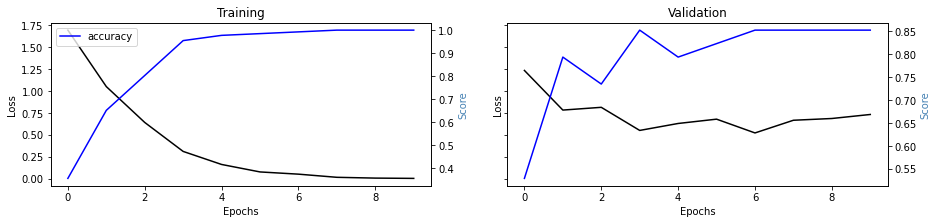

Iteração: 7 Fold: 7 Accuracy: 0.6666666666666666, Mean Accuracy: 0.7551020408163265
Epoch 1/10
17/17 [==============================] - 10s 210ms/step - loss: 1.8655 - accuracy: 0.2744 - val_loss: 1.5478 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.2732 - accuracy: 0.5945 - val_loss: 1.4408 - val_accuracy: 0.4412
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.6818 - accuracy: 0.7452 - val_loss: 1.0987 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.3720 - accuracy: 0.9275 - val_loss: 1.1992 - val_accuracy: 0.5588
Epoch 5/10
17/17 [==============================] - 2s 109ms/step - loss: 0.3146 - accuracy: 0.9323 - val_loss: 1.3857 - val_accuracy: 0.5882
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0780 - accuracy: 0.9972 - val_loss: 1.2661 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 110ms/st

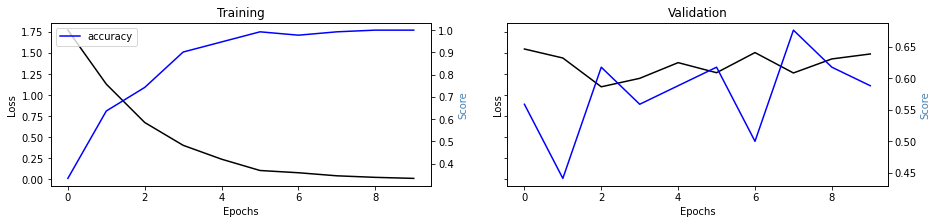

Iteração: 7 Fold: 8 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7559523809523809
Epoch 1/10
17/17 [==============================] - 10s 208ms/step - loss: 1.8960 - accuracy: 0.2033 - val_loss: 1.3905 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 115ms/step - loss: 1.4073 - accuracy: 0.5705 - val_loss: 1.1785 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 112ms/step - loss: 0.9373 - accuracy: 0.7431 - val_loss: 0.6494 - val_accuracy: 0.8235
Epoch 4/10
17/17 [==============================] - 2s 115ms/step - loss: 0.5095 - accuracy: 0.8976 - val_loss: 0.4251 - val_accuracy: 0.8529
Epoch 5/10
17/17 [==============================] - 2s 115ms/step - loss: 0.2501 - accuracy: 0.9314 - val_loss: 0.3445 - val_accuracy: 0.9118
Epoch 6/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1396 - accuracy: 0.9826 - val_loss: 0.4668 - val_accuracy: 0.8529
Epoch 7/10
17/17 [==============================] - 2s 112ms/st

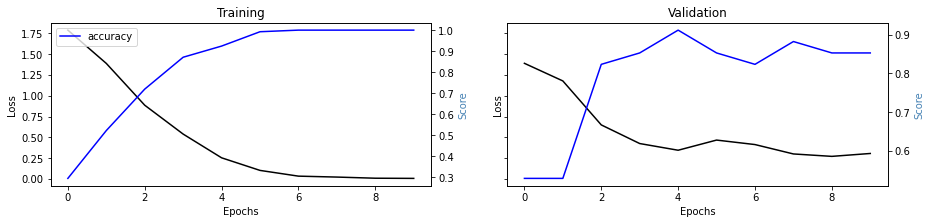

Iteração: 7 Fold: 9 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7592592592592592
Epoch 1/10
17/17 [==============================] - 11s 209ms/step - loss: 1.9067 - accuracy: 0.2589 - val_loss: 1.4799 - val_accuracy: 0.6176
Epoch 2/10
17/17 [==============================] - 2s 112ms/step - loss: 1.3109 - accuracy: 0.6279 - val_loss: 1.0877 - val_accuracy: 0.7059
Epoch 3/10
17/17 [==============================] - 2s 111ms/step - loss: 0.5899 - accuracy: 0.8678 - val_loss: 0.8027 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 111ms/step - loss: 0.3395 - accuracy: 0.9312 - val_loss: 0.8565 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.2688 - accuracy: 0.9397 - val_loss: 0.9419 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 111ms/step - loss: 0.1741 - accuracy: 0.9335 - val_loss: 1.0168 - val_accuracy: 0.7647
Epoch 7/10
17/17 [==============================] - 2s 112ms/st

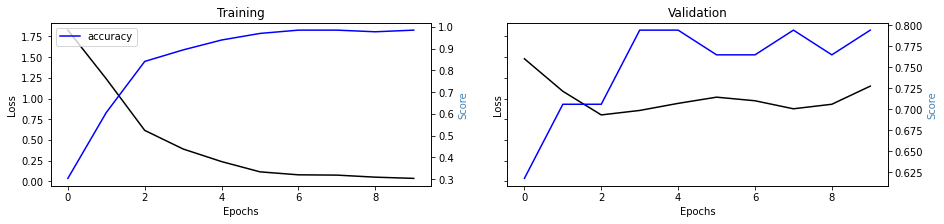

Iteração: 7 Fold: 10 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7642857142857142
Epoch 1/10
17/17 [==============================] - 11s 213ms/step - loss: 1.8432 - accuracy: 0.2841 - val_loss: 1.4210 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 116ms/step - loss: 1.2307 - accuracy: 0.6202 - val_loss: 1.1044 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 116ms/step - loss: 0.7052 - accuracy: 0.7738 - val_loss: 0.6347 - val_accuracy: 0.7941
Epoch 4/10
17/17 [==============================] - 2s 111ms/step - loss: 0.3025 - accuracy: 0.9205 - val_loss: 0.5464 - val_accuracy: 0.8235
Epoch 5/10
17/17 [==============================] - 2s 114ms/step - loss: 0.1602 - accuracy: 0.9848 - val_loss: 1.0918 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 111ms/step - loss: 0.1543 - accuracy: 0.9704 - val_loss: 0.6071 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 117ms/s

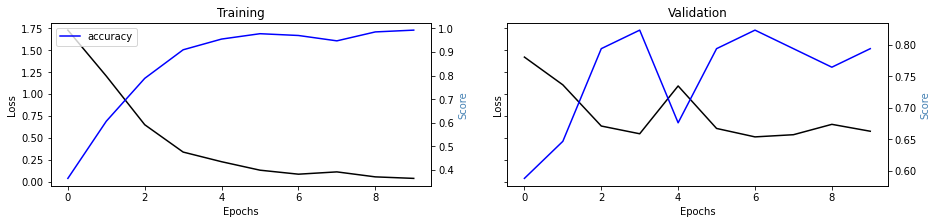

Iteração: 8 Fold: 1 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7142857142857143
Epoch 1/10
17/17 [==============================] - 10s 213ms/step - loss: 1.8450 - accuracy: 0.2793 - val_loss: 1.3737 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 114ms/step - loss: 1.0716 - accuracy: 0.5818 - val_loss: 1.0365 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 112ms/step - loss: 0.5936 - accuracy: 0.8673 - val_loss: 0.9185 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 115ms/step - loss: 0.4090 - accuracy: 0.9244 - val_loss: 0.6786 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 115ms/step - loss: 0.2641 - accuracy: 0.9588 - val_loss: 1.1695 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1274 - accuracy: 0.9847 - val_loss: 0.7072 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 112ms/st

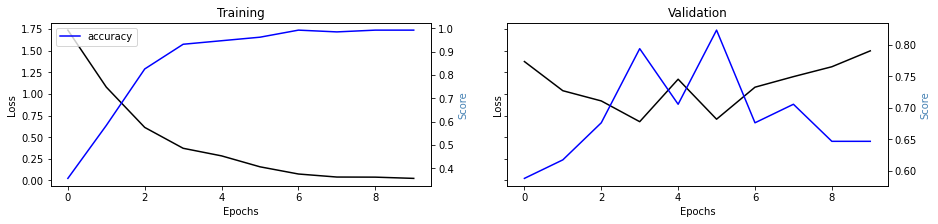

Iteração: 8 Fold: 2 Accuracy: 0.6904761904761905, Mean Accuracy: 0.7023809523809523
Epoch 1/10
17/17 [==============================] - 10s 208ms/step - loss: 1.8623 - accuracy: 0.2217 - val_loss: 1.5743 - val_accuracy: 0.2941
Epoch 2/10
17/17 [==============================] - 2s 112ms/step - loss: 1.4188 - accuracy: 0.5146 - val_loss: 1.4092 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 0.9320 - accuracy: 0.7811 - val_loss: 1.6482 - val_accuracy: 0.4706
Epoch 4/10
17/17 [==============================] - 2s 114ms/step - loss: 0.3760 - accuracy: 0.8934 - val_loss: 2.7591 - val_accuracy: 0.4118
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.7819 - accuracy: 0.7750 - val_loss: 0.9777 - val_accuracy: 0.6471
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.0926 - accuracy: 0.9946 - val_loss: 1.1481 - val_accuracy: 0.6471
Epoch 7/10
17/17 [==============================] - 2s 111ms/st

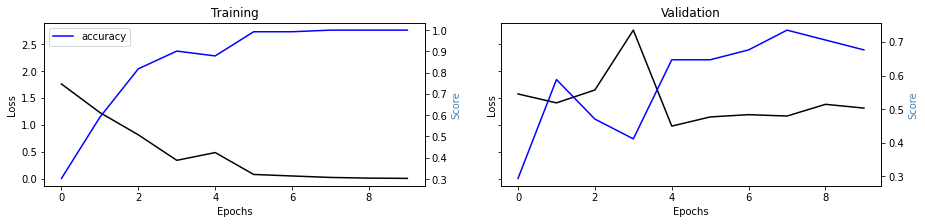

Iteração: 8 Fold: 3 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7380952380952381
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8470 - accuracy: 0.3073 - val_loss: 1.4391 - val_accuracy: 0.4706
Epoch 2/10
17/17 [==============================] - 2s 116ms/step - loss: 1.1661 - accuracy: 0.5587 - val_loss: 1.7449 - val_accuracy: 0.3824
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.7653 - accuracy: 0.7199 - val_loss: 1.0815 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 111ms/step - loss: 0.4282 - accuracy: 0.9382 - val_loss: 0.7964 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.2323 - accuracy: 0.9459 - val_loss: 0.7966 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.1709 - accuracy: 0.9525 - val_loss: 0.8959 - val_accuracy: 0.6471
Epoch 7/10
17/17 [==============================] - 2s 113ms/st

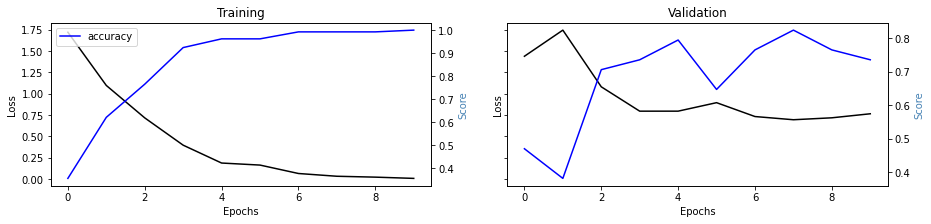

Iteração: 8 Fold: 4 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7440476190476191
Epoch 1/10
17/17 [==============================] - 11s 207ms/step - loss: 1.8209 - accuracy: 0.2223 - val_loss: 1.4727 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 112ms/step - loss: 1.1630 - accuracy: 0.6512 - val_loss: 1.4220 - val_accuracy: 0.5000
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.6125 - accuracy: 0.8180 - val_loss: 1.4571 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 112ms/step - loss: 0.3939 - accuracy: 0.8814 - val_loss: 0.8346 - val_accuracy: 0.7059
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1599 - accuracy: 0.9766 - val_loss: 0.8689 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.0736 - accuracy: 0.9970 - val_loss: 1.0799 - val_accuracy: 0.6765
Epoch 7/10
17/17 [==============================] - 2s 115ms/st

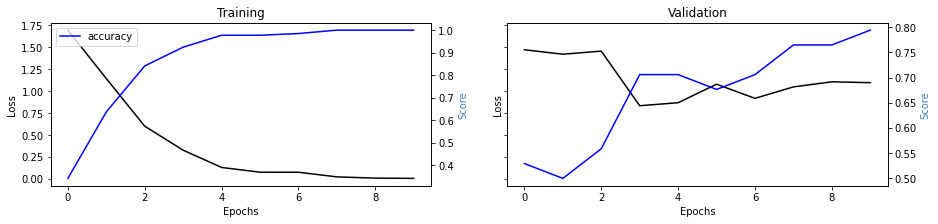

Iteração: 8 Fold: 5 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7428571428571429
Epoch 1/10
17/17 [==============================] - 10s 208ms/step - loss: 1.8796 - accuracy: 0.2496 - val_loss: 1.7332 - val_accuracy: 0.3235
Epoch 2/10
17/17 [==============================] - 2s 115ms/step - loss: 1.1279 - accuracy: 0.6068 - val_loss: 1.1107 - val_accuracy: 0.7941
Epoch 3/10
17/17 [==============================] - 2s 116ms/step - loss: 0.7074 - accuracy: 0.8273 - val_loss: 1.1743 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 116ms/step - loss: 0.3872 - accuracy: 0.8870 - val_loss: 1.7340 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 116ms/step - loss: 0.3935 - accuracy: 0.8726 - val_loss: 0.9401 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 113ms/step - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.7474 - val_accuracy: 0.8529
Epoch 7/10
17/17 [==============================] - 2s 114ms/st

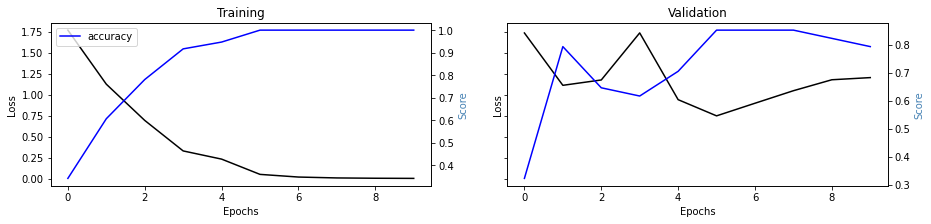

Iteração: 8 Fold: 6 Accuracy: 0.8095238095238095, Mean Accuracy: 0.753968253968254
Epoch 1/10
17/17 [==============================] - 10s 209ms/step - loss: 1.8696 - accuracy: 0.2475 - val_loss: 1.4083 - val_accuracy: 0.3235
Epoch 2/10
17/17 [==============================] - 2s 114ms/step - loss: 1.3107 - accuracy: 0.6128 - val_loss: 0.9958 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 115ms/step - loss: 0.7033 - accuracy: 0.8437 - val_loss: 0.9672 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 111ms/step - loss: 0.5059 - accuracy: 0.8328 - val_loss: 0.6932 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 115ms/step - loss: 0.2678 - accuracy: 0.9407 - val_loss: 0.6058 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 116ms/step - loss: 0.1601 - accuracy: 0.9777 - val_loss: 0.4536 - val_accuracy: 0.8529
Epoch 7/10
17/17 [==============================] - 2s 116ms/ste

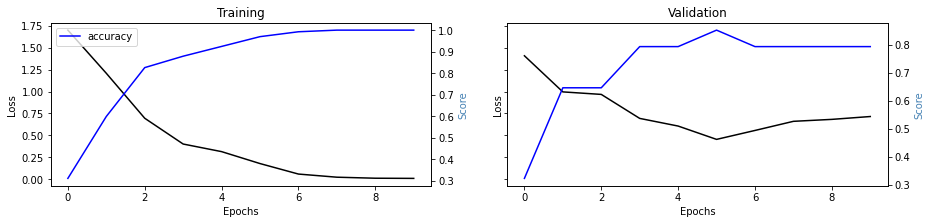

Iteração: 8 Fold: 7 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7551020408163265
Epoch 1/10
17/17 [==============================] - 11s 209ms/step - loss: 1.8228 - accuracy: 0.2558 - val_loss: 1.6008 - val_accuracy: 0.3529
Epoch 2/10
17/17 [==============================] - 2s 113ms/step - loss: 1.2374 - accuracy: 0.5741 - val_loss: 1.1616 - val_accuracy: 0.5588
Epoch 3/10
17/17 [==============================] - 2s 115ms/step - loss: 0.5637 - accuracy: 0.8563 - val_loss: 1.3665 - val_accuracy: 0.4118
Epoch 4/10
17/17 [==============================] - 2s 114ms/step - loss: 0.4493 - accuracy: 0.8727 - val_loss: 1.0020 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1147 - accuracy: 0.9914 - val_loss: 1.3172 - val_accuracy: 0.5882
Epoch 6/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1346 - accuracy: 0.9710 - val_loss: 1.5395 - val_accuracy: 0.5294
Epoch 7/10
17/17 [==============================] - 2s 113ms/st

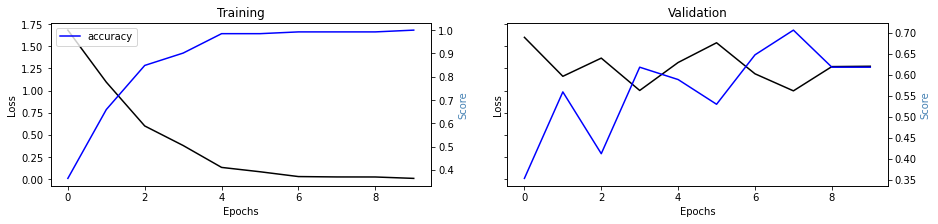

Iteração: 8 Fold: 8 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7559523809523809
Epoch 1/10
17/17 [==============================] - 11s 211ms/step - loss: 1.8708 - accuracy: 0.2540 - val_loss: 1.3216 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 114ms/step - loss: 1.2437 - accuracy: 0.5930 - val_loss: 1.1349 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 116ms/step - loss: 0.6967 - accuracy: 0.7957 - val_loss: 0.6270 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 115ms/step - loss: 0.4400 - accuracy: 0.8977 - val_loss: 0.3973 - val_accuracy: 0.8824
Epoch 5/10
17/17 [==============================] - 2s 118ms/step - loss: 0.1997 - accuracy: 0.9770 - val_loss: 0.3741 - val_accuracy: 0.9118
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.1078 - accuracy: 0.9662 - val_loss: 0.2751 - val_accuracy: 0.9412
Epoch 7/10
17/17 [==============================] - 2s 114ms/st

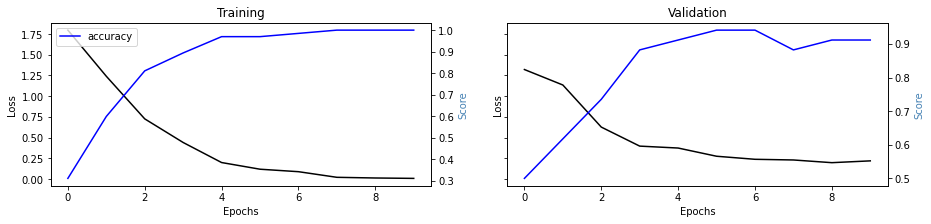

Iteração: 8 Fold: 9 Accuracy: 0.7380952380952381, Mean Accuracy: 0.753968253968254
Epoch 1/10
17/17 [==============================] - 10s 207ms/step - loss: 1.8172 - accuracy: 0.2395 - val_loss: 1.3088 - val_accuracy: 0.4412
Epoch 2/10
17/17 [==============================] - 2s 116ms/step - loss: 1.2486 - accuracy: 0.6148 - val_loss: 1.2432 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 0.7196 - accuracy: 0.7770 - val_loss: 0.8925 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 114ms/step - loss: 0.4255 - accuracy: 0.8696 - val_loss: 0.7286 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.2008 - accuracy: 0.9733 - val_loss: 0.5709 - val_accuracy: 0.8529
Epoch 6/10
17/17 [==============================] - 2s 117ms/step - loss: 0.0699 - accuracy: 0.9952 - val_loss: 1.3648 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 113ms/ste

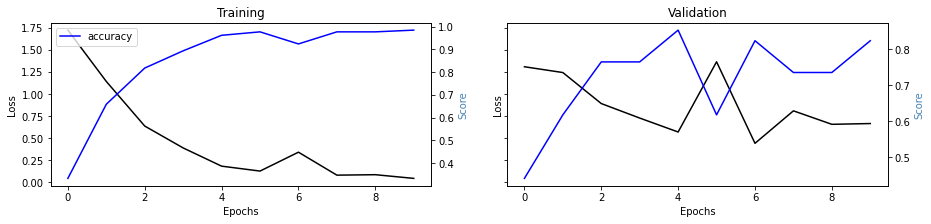

Iteração: 8 Fold: 10 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7619047619047619
Epoch 1/10
17/17 [==============================] - 10s 212ms/step - loss: 1.8975 - accuracy: 0.1872 - val_loss: 1.4465 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 116ms/step - loss: 1.3199 - accuracy: 0.5548 - val_loss: 1.2854 - val_accuracy: 0.5000
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.6986 - accuracy: 0.8280 - val_loss: 1.0452 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 116ms/step - loss: 0.3658 - accuracy: 0.9256 - val_loss: 0.6058 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 117ms/step - loss: 0.1078 - accuracy: 0.9824 - val_loss: 1.3087 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 115ms/step - loss: 0.2748 - accuracy: 0.9264 - val_loss: 0.6511 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 117ms/s

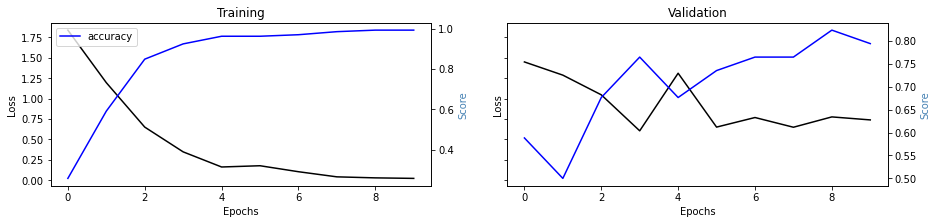

Iteração: 9 Fold: 1 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 214ms/step - loss: 1.7512 - accuracy: 0.3296 - val_loss: 1.6064 - val_accuracy: 0.3235
Epoch 2/10
17/17 [==============================] - 2s 114ms/step - loss: 1.1975 - accuracy: 0.6331 - val_loss: 1.5983 - val_accuracy: 0.4118
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 0.7207 - accuracy: 0.7794 - val_loss: 1.0313 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 114ms/step - loss: 0.4799 - accuracy: 0.9033 - val_loss: 0.9082 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 124ms/step - loss: 0.1907 - accuracy: 0.9705 - val_loss: 0.7555 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.0601 - accuracy: 0.9947 - val_loss: 1.0109 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 113ms/st

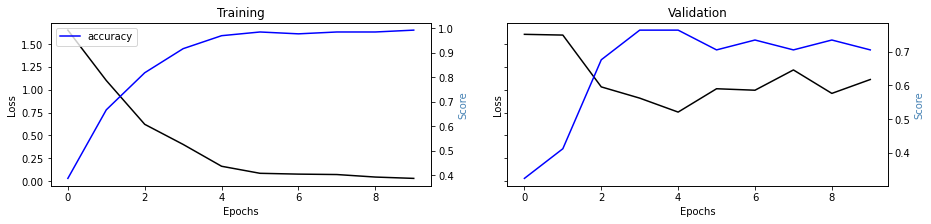

Iteração: 9 Fold: 2 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 212ms/step - loss: 1.7562 - accuracy: 0.3038 - val_loss: 1.4927 - val_accuracy: 0.4706
Epoch 2/10
17/17 [==============================] - 2s 114ms/step - loss: 1.1308 - accuracy: 0.5964 - val_loss: 1.0646 - val_accuracy: 0.5882
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 0.5861 - accuracy: 0.8658 - val_loss: 1.2588 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 114ms/step - loss: 0.2718 - accuracy: 0.9062 - val_loss: 1.0105 - val_accuracy: 0.6471
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.1063 - accuracy: 0.9970 - val_loss: 1.5846 - val_accuracy: 0.5588
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.2448 - accuracy: 0.9293 - val_loss: 1.0133 - val_accuracy: 0.7059
Epoch 7/10
17/17 [==============================] - 2s 113ms/st

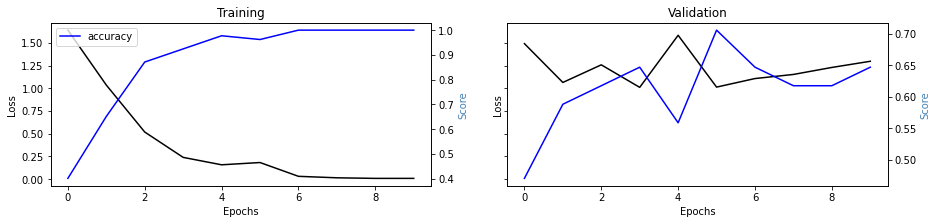

Iteração: 9 Fold: 3 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8095238095238094
Epoch 1/10
17/17 [==============================] - 10s 209ms/step - loss: 1.8239 - accuracy: 0.2025 - val_loss: 1.3064 - val_accuracy: 0.4706
Epoch 2/10
17/17 [==============================] - 2s 116ms/step - loss: 1.1723 - accuracy: 0.6143 - val_loss: 0.9858 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 111ms/step - loss: 0.6346 - accuracy: 0.8044 - val_loss: 0.7103 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.2427 - accuracy: 0.9493 - val_loss: 0.7703 - val_accuracy: 0.7059
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1271 - accuracy: 0.9704 - val_loss: 0.8135 - val_accuracy: 0.7647
Epoch 6/10
17/17 [==============================] - 2s 110ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.9976 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 114ms/st

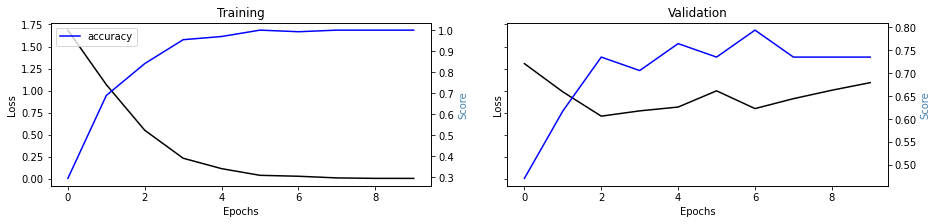

Iteração: 9 Fold: 4 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7976190476190476
Epoch 1/10
17/17 [==============================] - 11s 224ms/step - loss: 1.8088 - accuracy: 0.3072 - val_loss: 1.5750 - val_accuracy: 0.4412
Epoch 2/10
17/17 [==============================] - 2s 115ms/step - loss: 1.2216 - accuracy: 0.6160 - val_loss: 1.2928 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 115ms/step - loss: 0.7081 - accuracy: 0.8188 - val_loss: 0.9899 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 115ms/step - loss: 0.2767 - accuracy: 0.9177 - val_loss: 0.8198 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 115ms/step - loss: 0.1714 - accuracy: 0.9644 - val_loss: 0.6484 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 116ms/step - loss: 0.0550 - accuracy: 0.9937 - val_loss: 0.7671 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 117ms/st

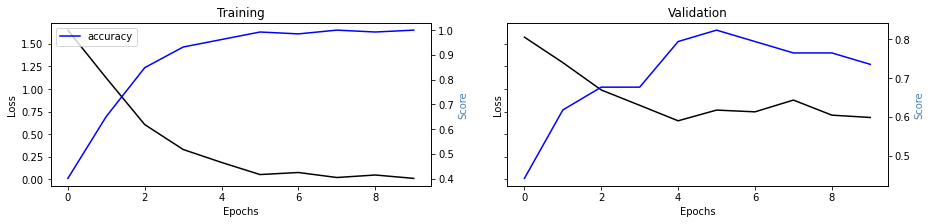

Iteração: 9 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7904761904761904
Epoch 1/10
17/17 [==============================] - 11s 212ms/step - loss: 1.7101 - accuracy: 0.4280 - val_loss: 1.4586 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 113ms/step - loss: 1.0248 - accuracy: 0.6959 - val_loss: 1.1740 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 111ms/step - loss: 0.6651 - accuracy: 0.7948 - val_loss: 0.9142 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 113ms/step - loss: 0.2840 - accuracy: 0.9417 - val_loss: 1.6545 - val_accuracy: 0.3529
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.3257 - accuracy: 0.9036 - val_loss: 0.6557 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 115ms/step - loss: 0.1166 - accuracy: 0.9824 - val_loss: 0.6687 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 112ms/st

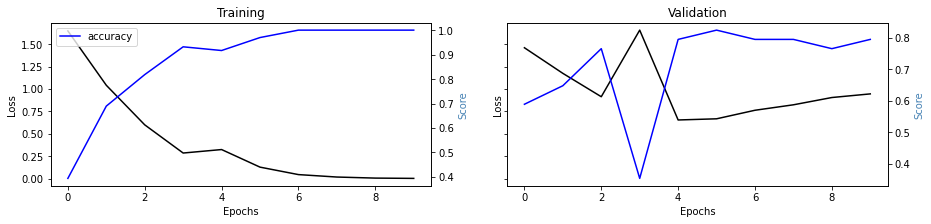

Iteração: 9 Fold: 6 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7857142857142856
Epoch 1/10
17/17 [==============================] - 11s 210ms/step - loss: 1.7502 - accuracy: 0.3550 - val_loss: 1.3209 - val_accuracy: 0.4706
Epoch 2/10
17/17 [==============================] - 2s 113ms/step - loss: 1.0675 - accuracy: 0.6227 - val_loss: 0.7821 - val_accuracy: 0.7647
Epoch 3/10
17/17 [==============================] - 2s 115ms/step - loss: 0.6856 - accuracy: 0.7543 - val_loss: 0.9728 - val_accuracy: 0.6176
Epoch 4/10
17/17 [==============================] - 2s 113ms/step - loss: 0.4307 - accuracy: 0.9024 - val_loss: 1.0830 - val_accuracy: 0.6471
Epoch 5/10
17/17 [==============================] - 2s 115ms/step - loss: 0.3265 - accuracy: 0.9280 - val_loss: 0.6147 - val_accuracy: 0.8235
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.1072 - accuracy: 0.9869 - val_loss: 0.5216 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 115ms/st

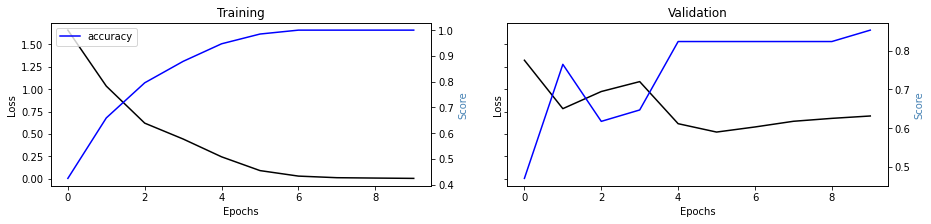

Iteração: 9 Fold: 7 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7823129251700679
Epoch 1/10
17/17 [==============================] - 11s 208ms/step - loss: 1.8120 - accuracy: 0.3302 - val_loss: 1.4221 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 115ms/step - loss: 1.1146 - accuracy: 0.6233 - val_loss: 1.2517 - val_accuracy: 0.4706
Epoch 3/10
17/17 [==============================] - 2s 112ms/step - loss: 0.6500 - accuracy: 0.8089 - val_loss: 1.2768 - val_accuracy: 0.5000
Epoch 4/10
17/17 [==============================] - 2s 116ms/step - loss: 0.3088 - accuracy: 0.9177 - val_loss: 1.1441 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1264 - accuracy: 0.9836 - val_loss: 1.3683 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 115ms/step - loss: 0.0839 - accuracy: 0.9772 - val_loss: 1.4266 - val_accuracy: 0.5294
Epoch 7/10
17/17 [==============================] - 2s 115ms/st

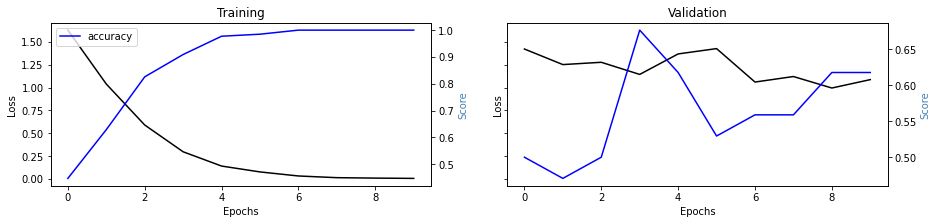

Iteração: 9 Fold: 8 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7827380952380951
Epoch 1/10
17/17 [==============================] - 10s 210ms/step - loss: 1.8987 - accuracy: 0.1865 - val_loss: 1.3449 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.3258 - accuracy: 0.6340 - val_loss: 0.9851 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 109ms/step - loss: 0.8961 - accuracy: 0.7277 - val_loss: 0.6085 - val_accuracy: 0.8529
Epoch 4/10
17/17 [==============================] - 2s 112ms/step - loss: 0.4427 - accuracy: 0.9071 - val_loss: 0.3183 - val_accuracy: 0.9118
Epoch 5/10
17/17 [==============================] - 2s 114ms/step - loss: 0.2449 - accuracy: 0.9195 - val_loss: 0.3882 - val_accuracy: 0.8529
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.0892 - accuracy: 1.0000 - val_loss: 0.3694 - val_accuracy: 0.8824
Epoch 7/10
17/17 [==============================] - 2s 112ms/st

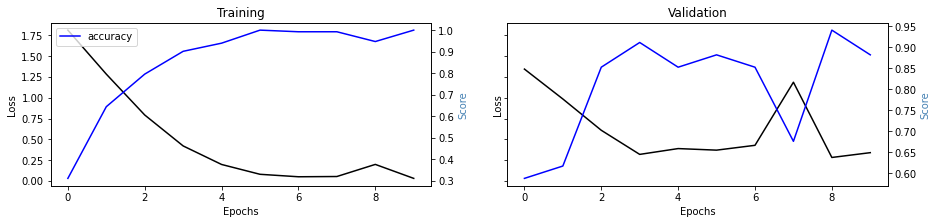

Iteração: 9 Fold: 9 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7857142857142856
Epoch 1/10
17/17 [==============================] - 11s 205ms/step - loss: 1.8465 - accuracy: 0.3313 - val_loss: 0.9823 - val_accuracy: 0.7647
Epoch 2/10
17/17 [==============================] - 2s 117ms/step - loss: 1.0541 - accuracy: 0.6739 - val_loss: 0.8643 - val_accuracy: 0.7941
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 0.8160 - accuracy: 0.7385 - val_loss: 1.2358 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 113ms/step - loss: 0.3944 - accuracy: 0.8974 - val_loss: 0.5034 - val_accuracy: 0.7941
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1523 - accuracy: 0.9698 - val_loss: 0.7159 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 111ms/step - loss: 0.2379 - accuracy: 0.9122 - val_loss: 0.5196 - val_accuracy: 0.8529
Epoch 7/10
17/17 [==============================] - 2s 117ms/st

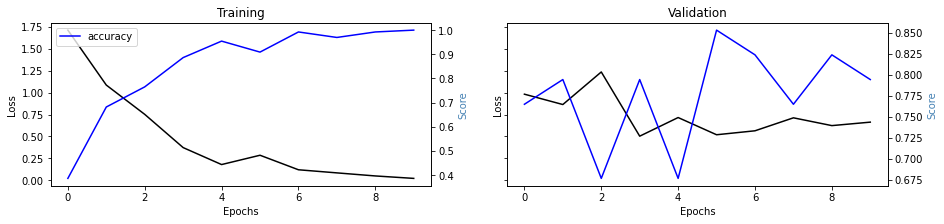

Iteração: 9 Fold: 10 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
Epoch 1/10
17/17 [==============================] - 11s 213ms/step - loss: 1.7826 - accuracy: 0.3217 - val_loss: 1.4832 - val_accuracy: 0.3235
Epoch 2/10
17/17 [==============================] - 2s 115ms/step - loss: 1.1256 - accuracy: 0.6518 - val_loss: 1.1253 - val_accuracy: 0.6765
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.6562 - accuracy: 0.8390 - val_loss: 1.0061 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 115ms/step - loss: 0.3384 - accuracy: 0.9342 - val_loss: 0.7339 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 114ms/step - loss: 0.3163 - accuracy: 0.9205 - val_loss: 0.5820 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.1845 - accuracy: 0.9549 - val_loss: 0.9601 - val_accuracy: 0.6765
Epoch 7/10
17/17 [==============================] - 2s 115ms/s

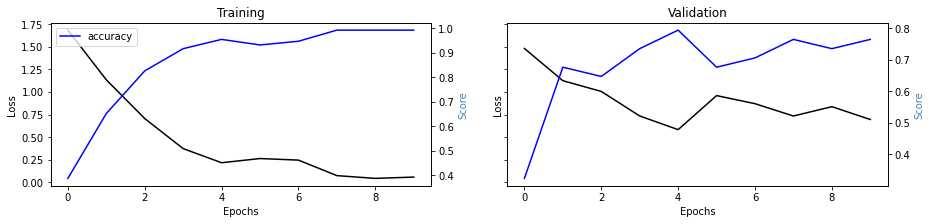

Iteração: 10 Fold: 1 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 216ms/step - loss: 1.8434 - accuracy: 0.2809 - val_loss: 1.3007 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 109ms/step - loss: 1.1970 - accuracy: 0.6160 - val_loss: 1.5765 - val_accuracy: 0.4706
Epoch 3/10
17/17 [==============================] - 2s 110ms/step - loss: 0.8872 - accuracy: 0.7290 - val_loss: 0.7872 - val_accuracy: 0.7353
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 0.4039 - accuracy: 0.8523 - val_loss: 0.7819 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.1729 - accuracy: 0.9620 - val_loss: 1.0215 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 108ms/step - loss: 0.2129 - accuracy: 0.9408 - val_loss: 0.4911 - val_accuracy: 0.8235
Epoch 7/10
17/17 [==============================] - 2s 116ms/s

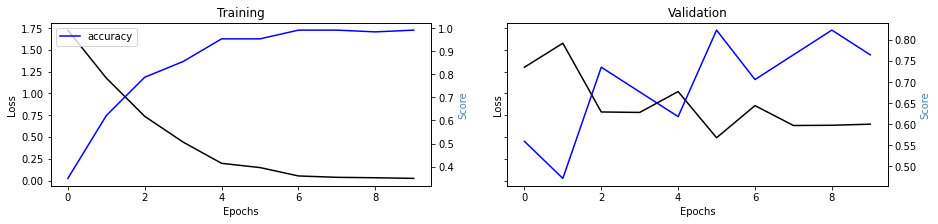

Iteração: 10 Fold: 2 Accuracy: 0.6904761904761905, Mean Accuracy: 0.7380952380952381
Epoch 1/10
17/17 [==============================] - 11s 208ms/step - loss: 1.8318 - accuracy: 0.2739 - val_loss: 1.6208 - val_accuracy: 0.4706
Epoch 2/10
17/17 [==============================] - 2s 112ms/step - loss: 1.2106 - accuracy: 0.6559 - val_loss: 1.1345 - val_accuracy: 0.6176
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.6035 - accuracy: 0.8907 - val_loss: 1.0288 - val_accuracy: 0.6765
Epoch 4/10
17/17 [==============================] - 2s 112ms/step - loss: 0.3255 - accuracy: 0.9428 - val_loss: 1.0637 - val_accuracy: 0.6176
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1480 - accuracy: 0.9683 - val_loss: 1.0451 - val_accuracy: 0.6471
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.0705 - accuracy: 0.9847 - val_loss: 1.2548 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 113ms/s

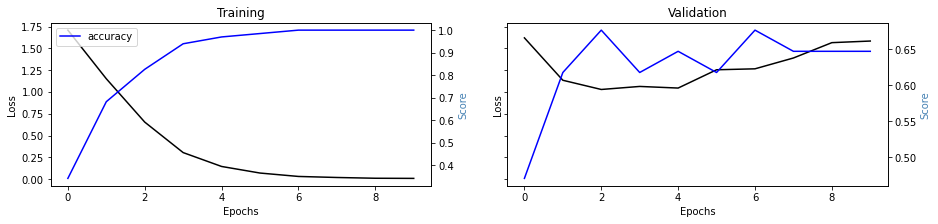

Iteração: 10 Fold: 3 Accuracy: 0.8809523809523809, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 209ms/step - loss: 1.8460 - accuracy: 0.2801 - val_loss: 1.3449 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 110ms/step - loss: 1.0997 - accuracy: 0.6642 - val_loss: 0.9398 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 112ms/step - loss: 0.5522 - accuracy: 0.8461 - val_loss: 0.9910 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 110ms/step - loss: 0.3704 - accuracy: 0.8765 - val_loss: 0.7695 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.2127 - accuracy: 0.9529 - val_loss: 0.8592 - val_accuracy: 0.7353
Epoch 6/10
17/17 [==============================] - 2s 111ms/step - loss: 0.1140 - accuracy: 0.9786 - val_loss: 0.7537 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 110ms/s

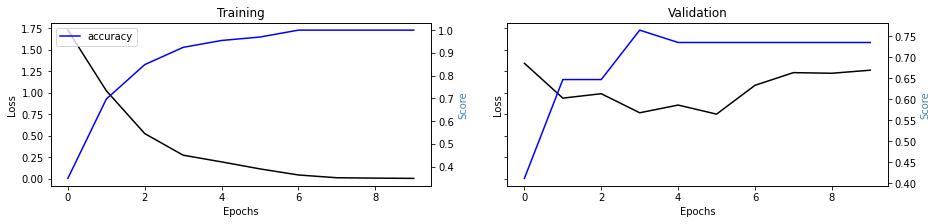

Iteração: 10 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
Epoch 1/10
17/17 [==============================] - 11s 211ms/step - loss: 1.8211 - accuracy: 0.2658 - val_loss: 1.6161 - val_accuracy: 0.4118
Epoch 2/10
17/17 [==============================] - 2s 118ms/step - loss: 1.1247 - accuracy: 0.6619 - val_loss: 1.3368 - val_accuracy: 0.4706
Epoch 3/10
17/17 [==============================] - 2s 112ms/step - loss: 0.6875 - accuracy: 0.8139 - val_loss: 1.1883 - val_accuracy: 0.5588
Epoch 4/10
17/17 [==============================] - 2s 112ms/step - loss: 0.7049 - accuracy: 0.7672 - val_loss: 1.1556 - val_accuracy: 0.4706
Epoch 5/10
17/17 [==============================] - 2s 115ms/step - loss: 0.2729 - accuracy: 0.9811 - val_loss: 1.0931 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.0596 - accuracy: 0.9983 - val_loss: 1.2488 - val_accuracy: 0.6176
Epoch 7/10
17/17 [==============================] - 2s 117ms/s

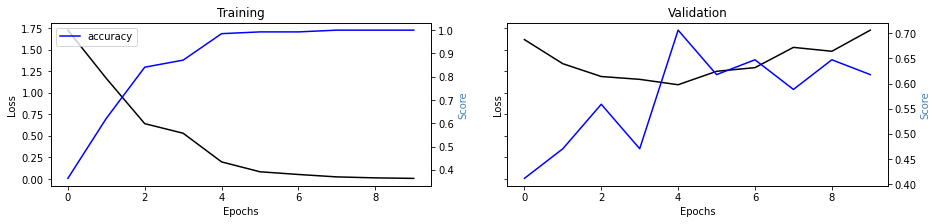

Iteração: 10 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.780952380952381
Epoch 1/10
17/17 [==============================] - 11s 206ms/step - loss: 1.8075 - accuracy: 0.2156 - val_loss: 1.4370 - val_accuracy: 0.5882
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.0184 - accuracy: 0.6260 - val_loss: 1.1955 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 115ms/step - loss: 0.5915 - accuracy: 0.8465 - val_loss: 1.0716 - val_accuracy: 0.6471
Epoch 4/10
17/17 [==============================] - 2s 113ms/step - loss: 0.2910 - accuracy: 0.9480 - val_loss: 0.7970 - val_accuracy: 0.8235
Epoch 5/10
17/17 [==============================] - 2s 110ms/step - loss: 0.1535 - accuracy: 0.9828 - val_loss: 0.9863 - val_accuracy: 0.7059
Epoch 6/10
17/17 [==============================] - 2s 113ms/step - loss: 0.0383 - accuracy: 1.0000 - val_loss: 0.8669 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 116ms/st

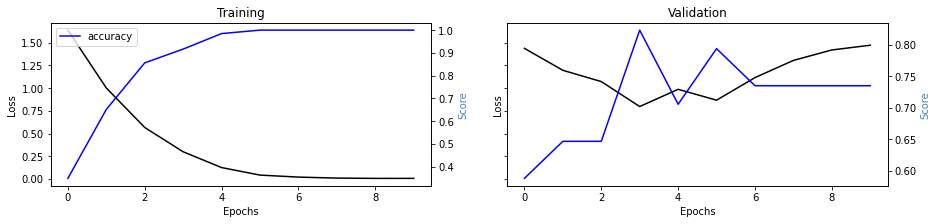

Iteração: 10 Fold: 6 Accuracy: 0.6666666666666666, Mean Accuracy: 0.7619047619047619
Epoch 1/10
17/17 [==============================] - 11s 209ms/step - loss: 1.8707 - accuracy: 0.2610 - val_loss: 1.3711 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 2s 117ms/step - loss: 1.2734 - accuracy: 0.5822 - val_loss: 1.1620 - val_accuracy: 0.5294
Epoch 3/10
17/17 [==============================] - 2s 116ms/step - loss: 0.6409 - accuracy: 0.8598 - val_loss: 0.9539 - val_accuracy: 0.7059
Epoch 4/10
17/17 [==============================] - 2s 117ms/step - loss: 0.3412 - accuracy: 0.9032 - val_loss: 0.7796 - val_accuracy: 0.7353
Epoch 5/10
17/17 [==============================] - 2s 117ms/step - loss: 0.1400 - accuracy: 0.9919 - val_loss: 0.7054 - val_accuracy: 0.7941
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.1007 - accuracy: 0.9740 - val_loss: 1.3050 - val_accuracy: 0.6471
Epoch 7/10
17/17 [==============================] - 2s 114ms/s

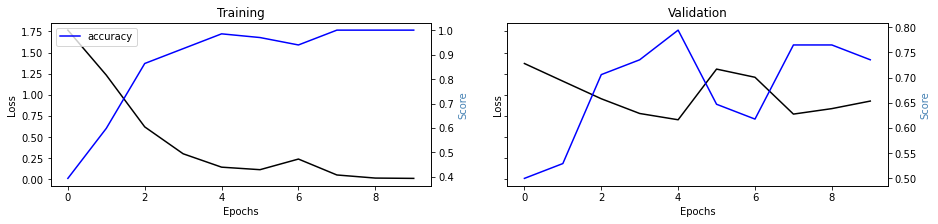

Iteração: 10 Fold: 7 Accuracy: 0.6428571428571429, Mean Accuracy: 0.7448979591836735
Epoch 1/10
17/17 [==============================] - 11s 208ms/step - loss: 1.7982 - accuracy: 0.3005 - val_loss: 1.4369 - val_accuracy: 0.5294
Epoch 2/10
17/17 [==============================] - 2s 111ms/step - loss: 1.0164 - accuracy: 0.7385 - val_loss: 1.1077 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.5328 - accuracy: 0.8786 - val_loss: 1.7967 - val_accuracy: 0.4412
Epoch 4/10
17/17 [==============================] - 2s 116ms/step - loss: 0.3556 - accuracy: 0.8753 - val_loss: 0.9282 - val_accuracy: 0.6765
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.1091 - accuracy: 0.9937 - val_loss: 0.8132 - val_accuracy: 0.6765
Epoch 6/10
17/17 [==============================] - 2s 113ms/step - loss: 0.0310 - accuracy: 0.9978 - val_loss: 0.9824 - val_accuracy: 0.7353
Epoch 7/10
17/17 [==============================] - 2s 114ms/s

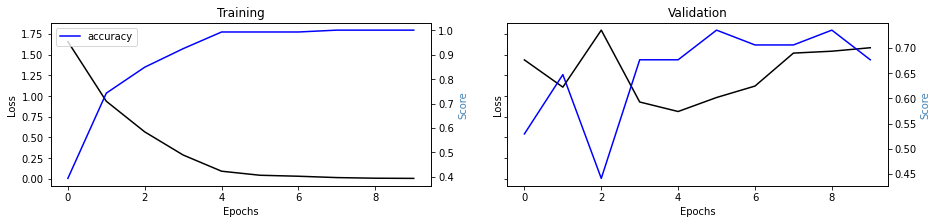

Iteração: 10 Fold: 8 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7410714285714286
Epoch 1/10
17/17 [==============================] - 11s 215ms/step - loss: 1.8405 - accuracy: 0.2900 - val_loss: 1.3074 - val_accuracy: 0.6176
Epoch 2/10
17/17 [==============================] - 2s 113ms/step - loss: 1.2962 - accuracy: 0.5907 - val_loss: 0.9989 - val_accuracy: 0.7059
Epoch 3/10
17/17 [==============================] - 2s 113ms/step - loss: 0.7398 - accuracy: 0.7856 - val_loss: 0.6488 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 113ms/step - loss: 0.3396 - accuracy: 0.9137 - val_loss: 0.7870 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 113ms/step - loss: 0.2452 - accuracy: 0.9437 - val_loss: 0.3304 - val_accuracy: 0.8824
Epoch 6/10
17/17 [==============================] - 2s 112ms/step - loss: 0.1116 - accuracy: 0.9818 - val_loss: 0.6563 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 110ms/s

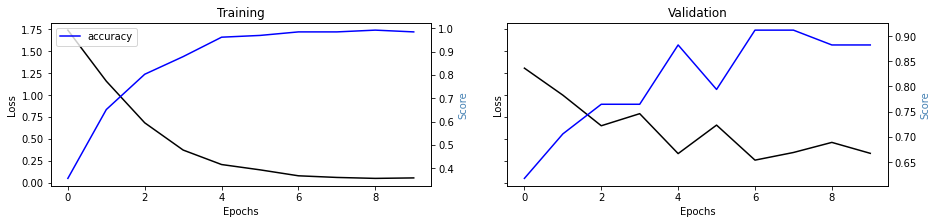

Iteração: 10 Fold: 9 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7433862433862434
Epoch 1/10
17/17 [==============================] - 10s 212ms/step - loss: 1.8699 - accuracy: 0.2495 - val_loss: 1.2248 - val_accuracy: 0.5588
Epoch 2/10
17/17 [==============================] - 2s 116ms/step - loss: 1.2360 - accuracy: 0.6291 - val_loss: 1.0192 - val_accuracy: 0.6471
Epoch 3/10
17/17 [==============================] - 2s 114ms/step - loss: 0.7989 - accuracy: 0.7385 - val_loss: 0.7317 - val_accuracy: 0.7647
Epoch 4/10
17/17 [==============================] - 2s 114ms/step - loss: 0.4521 - accuracy: 0.8794 - val_loss: 0.7944 - val_accuracy: 0.7647
Epoch 5/10
17/17 [==============================] - 2s 112ms/step - loss: 0.2083 - accuracy: 0.9689 - val_loss: 1.5676 - val_accuracy: 0.6176
Epoch 6/10
17/17 [==============================] - 2s 114ms/step - loss: 0.3940 - accuracy: 0.8959 - val_loss: 0.5792 - val_accuracy: 0.7941
Epoch 7/10
17/17 [==============================] - 2s 114ms/s

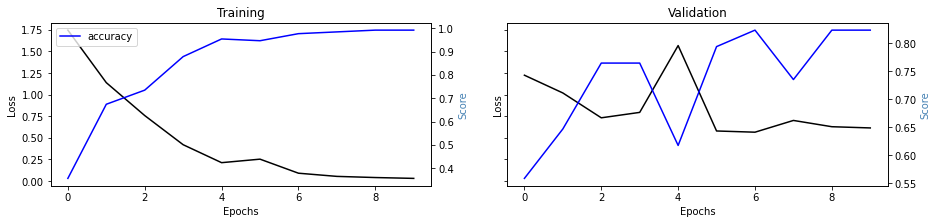

Iteração: 10 Fold: 10 Accuracy: 0.8333333333333334, Mean Accuracy: 0.7523809523809524


In [39]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    fold=0
#     conf_matrix_list_of_arrays = []

    k=10
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):

        fold +=1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=True, 
                                                            model=None, epochs=10, batch_size=8)
        # Validade Test Set
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays.append(conf_matrix)
        #
        accrs.append(accr)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

In [54]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

ZeroDivisionError: ignored

In [53]:
final_mean

[]

### Evaluate

#### Plot Metrics Resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.83	      0.71	      0.77	      0.72	      0.84
Design Document     	      0.33	       0.5	       0.4	      0.37	      0.72
License             	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Release Notes       	      0.88	       1.0	      0.93	      0.92	      0.98
Requirement Document	       1.0	       0.5	      0.67	       0.7	      0.75
Setup Files         	       1.0	       1.0	       1.0	       1.0	       1.0

Macro Average       	      0.86	      0.82	      0.82	      0.81	       0.9
Micro Average       	      0.89	      0.89	      0.89	       1.0	      0.94


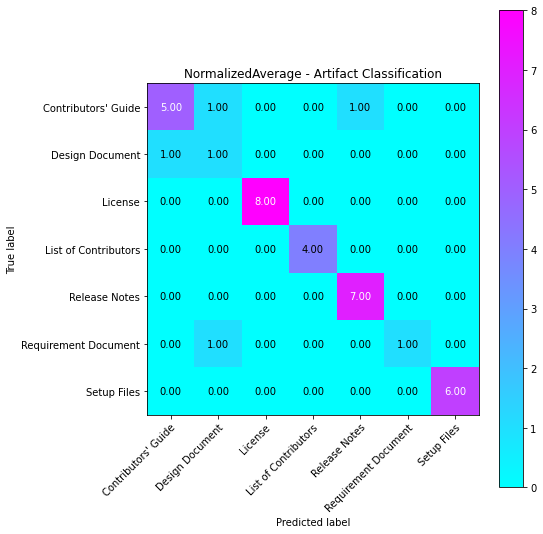

In [42]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## Word2Vec with Conventional Machine Learning

### Create the Feature Vector With Word2Vec

In [43]:
class Word2VecVectorizer:
  def __init__(self, word_vect):
    print("Loading in word vectors...")
    self.word_vectors = word_vect
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

### Vectorization

In [48]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(word_vect)
# Get the sentence embeddings for the train and test datasets
X = corpus

y = df["Label"].values

# Use for mNB
from sklearn.preprocessing import MinMaxScaler, normalize
def normalizer(X):
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    normalized_X = normalize(scaled_X, norm='max', axis=0, copy=True)
    return(normalized_X)

Loading in word vectors...
Finished loading in word vectors


In [49]:
def encode_y_train(y_train):
    vectorizer = LabelEncoder()
    y_train = vectorizer.fit_transform(y_train)
    return y_train

### Cross Validation and Fitting the Model

In [50]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y))}

In [51]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        X_train = vectorizer.fit_transform(X_train)
    #     X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
    #     X_test = normalizer(X_test) # Use for mNB

        y_train=encode_y_train(y_train)

        # train classifier
        model = rf.fit(X_train, y_train)
        # test
        predicted_prob = model.predict_proba(X_test)
        predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
                 predicted_prob]
    #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accr = metrics.accuracy_score(y_test, predicted)
        accrs.append(accr)
        preds.append(predicted)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

AttributeError: ignored

In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

### Evaluate

#### Plot Metrics Resume and Confusion Matrix

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    # conf_matrix_list_of_arrays = []
    k=10
    fold = 0
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB

        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}

        model = VotingClassifier(estimators=[
            ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[1,1,2,1])
        model = model.fit(X_train, y_train)

        predicted = model.predict(X_test)
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
        #    
        accrs.append(accr)
    #     print(metrics.classification_report(y_test, predicted))

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

### Evaluate

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))